Pavel Chvykov <pchvykov at gmail...>

Code for simulations and data analysis for the paper "Emergent order from mixed chaos at low temperature"

In [990]:
# Check here for versions of all the packages used (if there are issues)
# DON'T RUN - just expand the output to see what versions I used
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aext_assistant                    0.4.0
aext_assistant_server             0.4.0
aext_core                         0.4.0
aext_core_server                  0.4.0
aext_shared                       0.4.0
aiobotocore                       2.7.0
aiofiles                          22.1.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
aiosqlite                         0.18.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-auth                     0.8.5
anaconda-catalogs                 0.2.0
anaconda-cli-base                 0.5.2
anaconda-client                   1.13.0
anaconda-navigator                2.6.5
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                     

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import datetime as dt
import random as rnd
import copy
from tqdm import tqdm
import networkx as nx

from IPython.display import clear_output

Matplotlib is building the font cache; this may take a moment.


In [632]:
import random
def get_lyap(evol, IC, n_wind = 20, eps = 1e-7):
  '''
  Get Lyapunov exponents of the map given by evol at the initial conditions IC
  IC - array of ICs where each row is an IC: [n_IC, system_dim]
  evol - function that takes (IC, nSteps) and returns array with trajectories: [nSteps, n_IC, system_dim] 
  n_wind - steps to evolve trajectory for estimate local Lyapunov exp
  eps - initial small separation that we track
  Return: 1D array of local Lyapunov exponents for the privded IC 
  '''
  nIC = IC.shape[0];
  IC2 = np.r_[IC, IC + eps];# * np.random.randn(*IC.shape)]; # twin the IC
  trajs = evol(IC2, n_wind); # run the evolution
  ldist = 0.5*np.log10(np.sum((trajs[:, :nIC, :]-trajs[:, nIC:, :])**2, axis=2)) # get log separation
  ldist[~np.isfinite(ldist)] = np.log10(eps)/2; # basic nan-handling
  lfit = np.polyfit(np.arange(n_wind+1), ldist, deg=1);
  plt.figure(figsize=(3,2)); plt.plot(ldist); #plt.plot([0, n_wind], [lfit[1], lfit[1]+lfit[0]*n_wind],'k'); #[:,random.sample(range(nIC),30)]
  return lfit[0]

# Kicked Rotor-based systems

In [484]:
def run_KR( # General function for Kicked Rotor, Web Map and Kicked Harmonic Net
  max_steps=16384, nIC = 256, IC=None, early_stop=True, # time-steps and number of ICs
  K=3, per=1, b=1e-2, T=1e-3, freq=0, Lam=None, K_phase=[0], # kick, period, damping, temperature, connectivity matrix
  n_wind=20, n_thresh=16, lyap_thresh=None, ind_lyap=False, # lookback window to check for regularization, max unique to count as 'regular'
  #NOTE: use n_wind~20 for counting, n_wind~5 for Lyapunov - else saturates
  plot=False, reg_only=False):
  '''
  Function to run simple kicked rotor, web map, and kicked harmonic net:
  
  max_steps - sim steps when early_stop=False, or if not 100% regularized
  nIC - number of random initial conditions (IC) to propagate OR IC - array of specific IC to run [nIC, nOsc*2 (all th, then all v)]
  early_stop - whether to run for max_steps, or stop when all IC went into regular dynamics
  K, per, b, T - Simple Kicked Rotor parameters (set freq=0, Lam=None): Kick strenth, period, damping, temperature
  freq - when > 0, Web map - adds spring with this natural frequency 
  Lam - when not None, Kicked Harmonic Net (KHN) graph Laplacian, freq is then used for pinning springs (adds to Laplacian diagonal)
  n_wind - lookback window to check regularization. n_thresh - max unique coordinates to count state 'regular'
  lyap_thresh - if not None, instead use local Lyap exp to decide regularity: when <lyap_thresh, consdered 'regular'
  ind_lyap - instead compute local lyap exp per rotator (for KHN) - to check for local regularization [not used in the paper]
  plot, 
  - flags if to show plots, and if to plot only the trajectories that became regular (reg_only==1), or only irregular (reg_only== -1)
                  or only those that are regular and not simple fixed points (reg_only==2)
  Return: th,v (right before kick), fraction regularized (at all t), 
    data dictionry with: order parameter for KHN (fraction of partial Lyap exp that are small), last Lyapunov exponents
  '''
  
  if Lam is None: Nosc=1; LamSc = (2*np.pi*freq)**2;
  else: Nosc = Lam.shape[0]; LamSc = Lam + (2*np.pi*freq)**2 * np.eye(Nosc); # add to mean freq
  if IC is not None: nIC = IC.shape[0]
  th = np.zeros((max_steps, nIC, Nosc)); v=np.copy(th);
  if IC is None:
    th[0,:,:] = 4*np.pi*(np.random.rand(nIC,Nosc)-0.5); v[0,:,:] = 4*np.pi*(np.random.rand(nIC,Nosc)-0.5); 
  else: th[0,:,:] = IC[:, :Nosc]; v[0,:,:] = IC[:, Nosc:];
  # v[0,:,:] = 2*np.pi*np.random.randn(nIC,Nosc)
  # reg_bool = np.full((max_steps, nIC),False); 
  reg_frac = np.nan*np.zeros(max_steps); reg_frac_cnt = reg_frac.copy(); ord_par=[];
  noise = np.sqrt(2*b*T*per)*np.random.randn(max_steps,nIC,Nosc)
  
  if lyap_thresh is not None: # add nearby points to IC
    th = np.concatenate((th,th.copy()),axis=1); v = np.concatenate((v,v.copy()),axis=1);
    noise = np.concatenate((noise,noise.copy()),axis=1); # duplicated noise so separation is only due to chaos
    pert=1e-7; # set perturbation size
    th[0,nIC:,:]+=pert; v[0,nIC:,:]+=pert; # perturb the IC
    
  # Pre-compute harmonic evolution:
  A = np.block([[np.zeros((Nosc, Nosc)), -np.eye(Nosc)], [LamSc, b*np.eye(Nosc)]])
  # a, B = np.linalg.eig(A); Binv = np.linalg.inv(B) #Aexp=real(B(:,:,lsc)*diag(exp(-a(:,lsc)*tSeq(3)))*Binv(:,:,lsc));
  Aexp = sp.linalg.expm(-A*per); #print(Aexp);
  K_phase = np.array(K_phase)
  early_stop_cnt = 0; lyaps=[]
  
  for it in range(max_steps-1):
    v[it+1,:,:] = v[it,:,:] - K/per*np.sin(th[it,:,:]+K_phase[None,:]) + noise[it,:,:]
    # v[it+1,:] -= per*b*v[it,:]
    # th[it+1,:] = ((th[it,:] + per*v[it+1,:]+np.pi) % (2*np.pi)) - np.pi # for free rotation
    out = Aexp @ ((np.c_[th[it,:,:], v[it+1,:,:]]).T) # with springs
    th[it+1,:,:], v[it+1,:,:] = out[:Nosc,:].T, out[Nosc:,:].T
    if freq==0 and Nosc==1: th[it+1,:] = ((th[it+1,:]+np.pi)% (2*np.pi)) - np.pi 
    #### count unique points in past window to determine regularity
    if it>n_wind: # count ICs that are ordered now
      # Find ICs that had <=n_thresh unique coords out of last n_wind points:
      usePt=0; # look only at this particle when judging regularization
      hash_arr = 1234*np.round(th[it-n_wind:it+1,:nIC,usePt], decimals=1) + np.round(v[it-n_wind:it+1,:nIC,usePt], decimals=1) # hacky simple way to hash 2D -> 1D
      srtd = np.sort(hash_arr,axis=0) 
      nunique = (srtd[1:] != srtd[:-1]).sum(axis=0)+1 # a vectorized way to count number of unique elts in each column
      # reg_bool[it+1,:] = nunique <= n_thresh
      reg_IC_cnt = nunique <= n_thresh;
      reg_frac_cnt[it+1] = np.sum(reg_IC_cnt)/nIC
      if lyap_thresh is None:
        reg_IC = reg_IC_cnt;
        reg_frac[it+1] = reg_frac_cnt[it+1];
    if lyap_thresh is not None: # use Lyapunov exp to determine regularity
      if it>0 and it%n_wind==0:
        sl=slice(it+1-n_wind,it+2)
        dist = (th[sl,nIC:,:]-th[sl,:nIC,:])**2 + (v[sl,nIC:,:]-v[sl,:nIC,:])**2
        ldist = 0.5*np.log(np.sum(dist,axis=2)) # total spread 
        # ldist[ldist>np.log(10)]=np.nan; # saturates after
        lfit = np.polyfit(range(n_wind+1), ldist, deg=1)
        lyaps = lfit[0]
        reg_IC = lyaps<lyap_thresh;
        reg_frac[it+1] = np.sum(reg_IC)/nIC
        if ind_lyap: # get Lyap exp per oscillator
          ind_ldist = 0.5*np.log(dist) # spread per oscillator
          ind_lfit = np.polyfit(range(n_wind+1), np.reshape(ind_ldist,[ind_ldist.shape[0],-1]), deg=1)
          ind_ly = np.reshape(ind_lfit[0],[nIC,Nosc])
          ord_par.append(np.sum(ind_ly<lyap_thresh, axis=1)/Nosc)
        # plt.plot(ldist[:,5],'.'); 
        # plt.plot(ind_ldist[:,5,0],'.')
        # # plt.hist(lfit[0])
        # raise('aa')
        
        th[it+1,nIC:,:]=th[it+1,:nIC,:]+pert; v[it+1,nIC:,:]=v[it+1,:nIC,:]+pert; # reset for next rollout
      
    if early_stop and reg_frac[it+1]>0.99: early_stop_cnt+=1; # early stopping if everything regularized
    if early_stop_cnt>10: break
    
  if lyap_thresh is not None: th = th[:,:nIC,:]; v = v[:,:nIC,:]; # remove the twin trajectories
  
  # reg_frac=np.sum(reg_bool[:],axis=1)/nIC
  if plot:
    if reg_only==1: plIC = np.nonzero(reg_IC)[0]; # only plot regularized trajectories
    elif reg_only==2: plIC = np.nonzero(reg_IC & ~reg_IC_cnt)[0]; # only plot complex attractor trajectories
    elif reg_only== -1: plIC = np.nonzero(~reg_IC)[0]; # only plot NOT regularized trajectories
    else: plIC = range(nIC);
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(12,4))
    plt.subplot(131) # th dim are (max_steps, nIC, Nosc)
    plPt=0; plSt=round(0.8*it); 
    plt.plot(th[plSt:,plIC,plPt], v[plSt:,plIC,plPt], '.', ms=1); #plt.axis(2*np.pi*np.array([-1,1,-1,1]))
    plt.xlabel(r"$\theta$"); plt.ylabel('v');
    # plt.subplot(234); plt.plot(th[plSt:,plIC[0],plPt], '.', ms=1);
    plt.subplot(132)
    # plt.plot(th[plSt:,plIC,plPt], '.', ms=1);
    if lyap_thresh is not None: plt.plot(reg_frac[:it+1],'.', label="via Lyap"); 
    plt.plot(reg_frac_cnt[:it+1],'.', ms=1, label="via count"); plt.legend(); plt.ylim([0,1]); 
    plt.xlabel('sim steps'); plt.ylabel('fraction of ICs regularized');
    plt.subplot(133)
    if lyap_thresh is None:
      plt.hist(nunique, bins=np.arange(n_wind)+0.5, density=True)
      plt.xlabel('number of points in attractor'); plt.ylabel('fraction of IC')
    else: 
      # plt.hist(lfit[0], bins=20, density=True); plt.xlabel('local Lyapunov exponent'); plt.ylabel('fraction of IC')
      plt.plot(np.log10(np.e)*ldist[:,plIC][:,:5],'.'); plt.xlabel('time'); plt.ylabel('log10 Lyap distance')
      plt.title("Growth of perturbation for \n5 trajectories near end of sim")
    plt.tight_layout(); plt.show()
  data = {'ord_par': np.array(ord_par), 'lyaps': lyaps}
  return th, v, reg_frac[n_wind:it+1], data
    
def regularization_time(reg_frac, plot=False):
  '''
  Function to calculate the time it took the system to regularize (based on exponensial curve fit)
  reg_frac - reg_frac return from above function
  Return: fit curve parameters and their errors
  '''
  thresh=0.5;
  rem_frac=1-reg_frac; tDom = np.arange(len(reg_frac)); msk=reg_frac>thresh-0.15; # cut off starting tail
  if reg_frac[np.isfinite(reg_frac)][-1]<thresh: return None,None # did not regularize
  if sum(msk)<=5: return np.full(2,np.nan), np.full((2,2),np.nan)
  # log_rem = np.log(rem_frac); #msk=np.isfinite(log_rem);
  # lfit=np.polyfit(tDom[msk], log_rem[msk], deg=1, w=rem_frac[msk])
  lfit, cov = sp.optimize.curve_fit(lambda t,a,b: np.exp(-t/a + b),  tDom[msk],  rem_frac[msk], p0=(1000, 0.)) # <- less sensitive to tail
  # lfit, _ = sp.optimize.curve_fit(lambda t,a: np.exp(-t/a),  tDom,  rem_frac, p0=(100,)) # <- less sensitive to tail
  if plot:
    plt.plot(np.log(rem_frac),'.');
    plt.plot(tDom, (-tDom/lfit[0]+lfit[1]), 'k'); plt.ylim(bottom=-7) # + lfit[1]
    print(lfit) # want lfit[1]>0
  return lfit, cov

## - Kicked Harmonic Net runs

### -- Generate connectivity graph

3 types of connectiity graphs you can choose:

In [807]:
((16**2) - 16)/2

120.0

In [441]:
########## GENERATE RANDOM CONNECTIVITY MATRIX ############

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Initialization
Nosc, eigSpread = 4, 0.50  # Number of oscillators, eigenvalue sprea
prec = 1e-10  # Precision
np.random.seed(1)  # Random seed

# Create network graph
def mxGen(row, col):
#     return 10 * eigSpread * np.random.gamma(1 / (Nosc * eigSpread / 10), 1, (row, col))
    return eigSpread * np.random.binomial(1, 1/Nosc/eigSpread, (row, col)) # Eros-Renyi graph G(n,p)

Lam, nccMin = None, Nosc
for _ in range(100):  # Try to create a connected graph
    Ltmp = np.triu(mxGen(Nosc, Nosc), 1)
    Ltmp = Ltmp + Ltmp.T
    Ltmp = np.diag(Ltmp.sum(axis=0)) - Ltmp  # Laplacian matrix
    lam = np.linalg.eigvalsh(Ltmp)
    ncc = np.sum(np.abs(lam) < prec)  # Number of connected components
    if ncc <= 1:
        Lam = Ltmp
        break
    if ncc < nccMin:
        Lam, nccMin = Ltmp, ncc

if Lam is None:
    raise ValueError("Failed to create a connected graph")

# Lam[0, 0] *= 1.2  # Pin down the first particle
Lam = Lam / np.mean(np.linalg.eigvalsh(Lam))  # Normalize eigenvalues
Lam[np.abs(Lam) < prec] = 0  # Chop small values
print(np.linalg.eigvalsh(Lam))

[1.03761988e-16 1.00000000e+00 1.00000000e+00 2.00000000e+00]


In [3160]:
###### 1D loop connectivity
k0 = 0.1
Nper=Nosc;
Lam = np.diag(np.ones(Nosc-1), -1); Lam[0, -1] = 1; # Connectivity matrix K for a linear chain in a closed loop
Lam += Lam.T; Lam = np.diag(np.sum(Lam,axis=1)) - Lam; # make the Laplacian matrix
Lam += k0 * np.eye(Nosc) # phonon 'mass' - pinning to origin

In [3152]:
####### Lattice graph
k0 = 0.1
Nper = 4;
G = nx.grid_graph(dim=(Nper,)*2, periodic=True)
Lam = nx.adjacency_matrix(G, dtype=float)
Nosc = Lam.shape[0]
# Lam = np.diag(np.ones(Nosc-1), -1); Lam[0, -1] = 1; # Connectivity matrix K for a linear chain in a closed loop
Lam = np.diag(np.sum(Lam,axis=1)) - Lam; # make the Laplacian matrix
Lam += k0 * np.eye(Nosc) # phonon 'mass' - pinning to origin

In [873]:
#### Small-world graph
# Generate Watts–Strogatz small-world graph
G = nx.watts_strogatz_graph(n=16, k=4, p=0.5, seed=0)
# Unnormalized Laplacian (sparse by default)
L = nx.laplacian_matrix(G)  # SciPy sparse array
Lam=L.toarray()
print(Lam, np.linalg.eigvalsh(Ltmp).mean())

[[ 4 -1 -1  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [-1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0 -1]
 [-1 -1  4  0  0  0  0  0 -1  0  0  0 -1  0  0  0]
 [ 0 -1  0  6 -1 -1  0 -1  0 -1  0  0  0 -1  0  0]
 [ 0  0  0 -1  3  0 -1  0  0 -1  0  0  0  0  0  0]
 [ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1 -1  4  0 -1 -1  0  0  0  0  0  0]
 [ 0  0  0 -1  0 -1  0  4 -1 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0 -1 -1  4 -1  0  0  0  0  0  0]
 [ 0  0  0 -1 -1  0 -1 -1 -1  7  0 -1  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  3 -1  0  0 -1 -1]
 [ 0  0  0  0  0  0  0  0  0 -1 -1  3 -1  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0 -1  4 -1 -1  0]
 [ 0  0  0 -1  0  0  0  0  0  0  0  0 -1  3  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1 -1  0 -1  0  4  0]
 [-1 -1  0  0  0  0  0  0  0  0 -1  0  0 -1  0  4]] 0.9999999999999997


/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_69022/3026560901.py:11: RuntimeWarning: divide by zero encountered in divide
  LWidths = 5 * (EdWt - EdWt.min() + prec) / (EdWt.max() - EdWt.min())


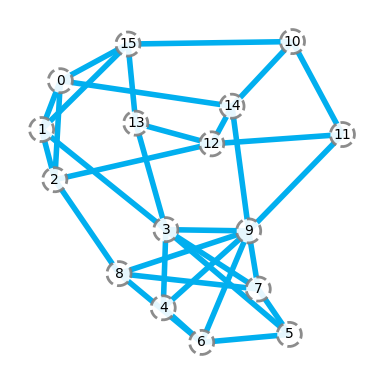

In [875]:
########### Visualize the generated network ###########
ev,EV = np.linalg.eigh(Lam)
# Visualization
# G = nx.grid_graph(dim=(5,5), periodic=False)
G = nx.from_numpy_array(-Lam+np.diag(np.diag(Lam)))  # Create graph
pos = nx.spring_layout(G, seed=0, weight='weight', k=0.1)  # Layout

# Calculate edge widths based on weights
weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
EdWt = np.log(weights)  # Log-transformed weights
LWidths = 5 * (EdWt - EdWt.min() + prec) / (EdWt.max() - EdWt.min())
LWidths[LWidths == np.inf] = 4  # Handling uniform weights

# Draw graph
# plt.figure(figsize=(4,3))
# nx.draw_networkx(G, pos, with_labels=True, width=LWidths, alpha=0.7, node_color='grey', 
#                  edge_color=np.array([1,176,240])/256, font_size=8, node_size=500)

fig, ax = plt.subplots(figsize=(4,4))
pc = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_color='white',       # white fill
    alpha=0.9,
    edgecolors='grey',        # grey outline
    linewidths=2.,           # outline width
)
# Make outlines dashed (Matplotlib supports this on PathCollection)
pc.set_linestyle('--')       # dashed border
# Draw edges and labels as desired
nx.draw_networkx_edges(G, pos, ax=ax, edge_color=np.array([1,176,240])/256, width=LWidths)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=10)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [3493]:
# Save connectivity gaph to reproduce later:
np.savetxt("Lam16_rnd_loose1.csv", Lam, delimiter=",")

In [891]:
# Load connectivity gaph:
Lam=np.genfromtxt("Lam16_rnd_loose.csv", delimiter=",", skip_header=0)
Lam.shape

(16, 16)

In [925]:
Lam

array([[ 1.26315789,  0.        ,  0.        , -0.42105263, -0.42105263,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.42105263,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.26315789,  0.        ,  0.        ,  0.        ,
        -0.42105263,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.42105263,  0.        ,  0.        ,  0.        , -0.42105263,
         0.        ],
       [ 0.        ,  0.        ,  1.26315789,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.42105263,
         0.        ,  0.        , -0.42105263,  0.        , -0.42105263,
         0.        ],
       [-0.42105263,  0.        ,  0.        ,  1.26315789,  0.        ,
         0.        , -0.42105263,  0.        ,  0.        ,  0.        ,
        -0.42105263,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.42105263,  0.        ,  0

### -- Run and plot dynamics

In [ ]:
K=1.5, freq=1/10, b=1e-1, T=0e-3, Lam=2*Lam16_rnd_loose,

In [502]:
K_phase = 0*2*np.pi*np.random.rand(Lam.shape[0])
K_phase

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

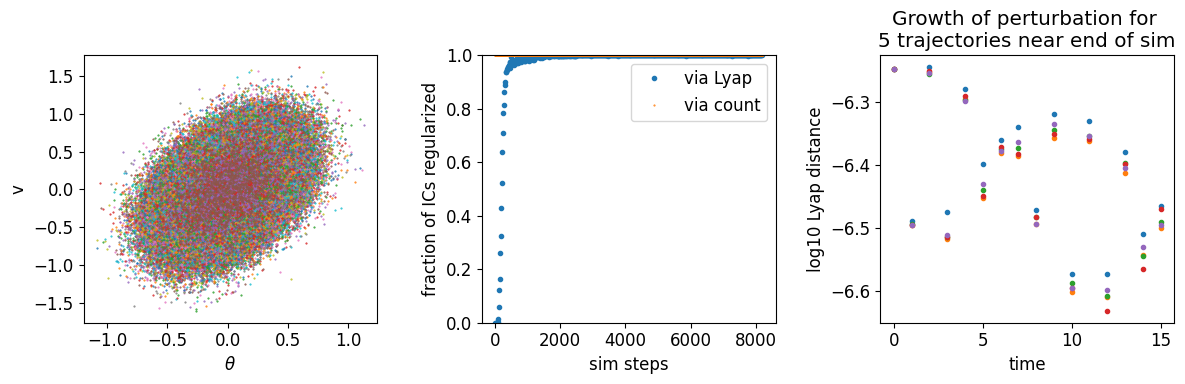

CPU times: user 10.5 s, sys: 2 s, total: 12.5 s
Wall time: 8.89 s


In [943]:
%%time
th,v,reg_frac,data = run_KR(max_steps=2*4*1024, nIC=2*128, early_stop=False, #IC = IC,
                                n_thresh=16, n_wind=15, lyap_thresh=0.0, ind_lyap=False,
                                # K=0.4, freq=1/10, b=5e-3, T=1115e-4, Lam=np.array([[1,-1],[-1,1]]),
                                K=1.4, freq=1/10, b=55e-3, T=1115e-4, Lam=2*Lam, #K_phase=K_phase,
                                # K=0.4, freq=1/10, b=5e-3, T=50e-5, Lam=2*Lam, #K_phase=K_phase, # 5, 1/8
                               plot=True, reg_only=0)
# regularization_time(reg_frac, plot=True)
# plt.xlim(0,200)

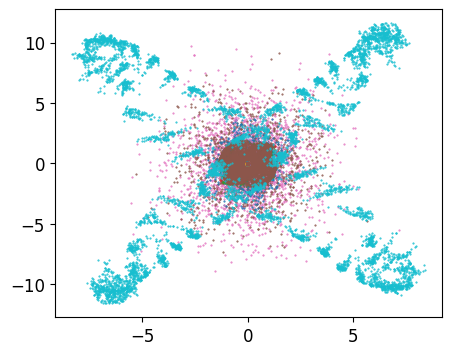

In [867]:
plSt=10000; plEd=th.shape[0]; plPt=0;
plt.figure(figsize=(5,4))
plt.plot(th[plSt:plEd,:,plPt], v[plSt:plEd,:,plPt],'.',ms=1); #plt.axis(np.array([-np.pi,np.pi,-5,5]));

In [879]:
# Load data:
import pickle
# Open the file in binary read mode ('rb')
with open("KHN16_attractor0.pkl", "rb") as file:
    data_ld = pickle.load(file)

print("Loaded dictionary:", data_ld.keys())
(th, v, plIC) = data_ld.values();

Loaded dictionary: dict_keys(['th', 'v', 'plIC'])


In [356]:
th.shape

(8192, 256, 16)

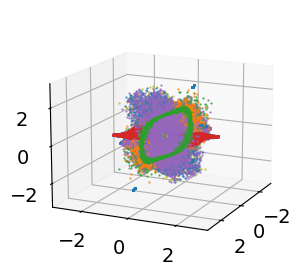

In [1157]:
######## 3D Plot ###########
# plt.figure(figsize=(3,3))
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(3,3))
ax.view_init(elev=15., azim=25) #ax.view_init(elev=15., azim=25)

plPt=(0,1,2);
plSt=round(5000); 
datX,datY,datZ = th[plSt:,:,plPt[0]], th[plSt:,:,plPt[1]], th[plSt:,:,plPt[2]]
ax_lim=1*np.pi*np.array([-1,1,-1,1,-1,1])
msk=np.full(datX.shape,True)
# msk=(ax_lim[0]<datX) & (datX<ax_lim[1]) & (ax_lim[2]<datY) & (datY<ax_lim[3]) & (ax_lim[4]<datZ) & (datZ<ax_lim[5]) 
# plt.rcParams.update({'font.size': 22})
for nic in range(th.shape[1]):
  ax.plot(datX[msk[:,nic],nic],datY[msk[:,nic],nic],datZ[msk[:,nic],nic], '.', ms=1)#, alpha=0.1); 
# plt.ylim(-2*np.pi, 2*np.pi); plt.xlim(-3*np.pi, 3*np.pi);
plt.axis(ax_lim)
# plt.xlabel(r"$\theta_1$"); plt.ylabel(r"$\theta_2$"); ax.set_zlabel(r"$\theta_3$")
plt.tight_layout()
plt.show()

(16384, 64, 16) 1


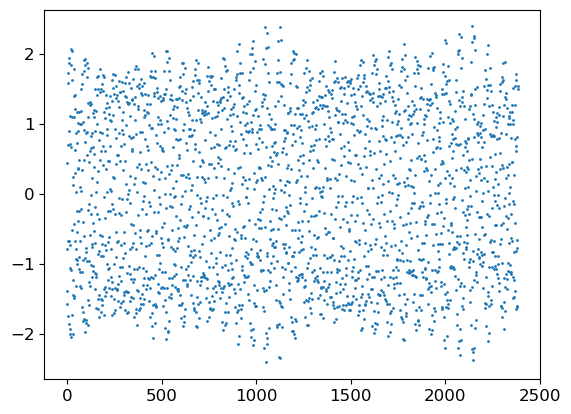

In [308]:
# plot specific trajectories
plIC = np.nonzero(np.max(th[10000:,:,0],axis=0)>1)[0][[1]]
print(th.shape, len(plIC))
plt.plot(np.squeeze(th[14000:,plIC,7]),'.',ms=2);

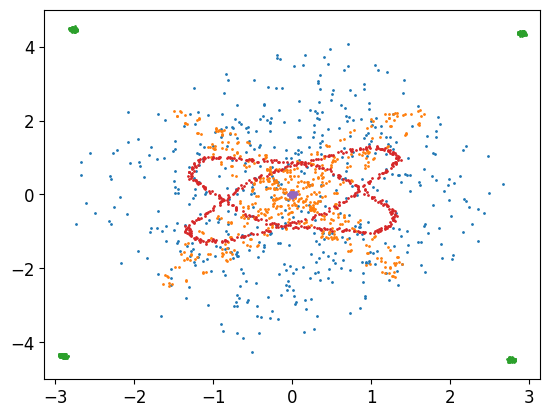

In [889]:
# Get points in the attractor
plSt=round(2*4*1024 - 8*64); plPt=0;
datX,datY= th[plSt:,:,:], v[plSt:,:,:]
# msk = np.max(np.abs(datX[:,:,plPt]), axis=0)>0.4 # only keep non-trivial
msk = (plIC); # is specified IC
# plt.figure(figsize=(4,3))
plt.plot(datX[:,msk,plPt], datY[:,msk,plPt],'.',ms=2); plt.axis(np.array([-np.pi,np.pi,-5,5]));
IC_attr = np.reshape(np.concatenate([datX[:,msk,:],datY[:,msk,:]], axis=2),[-1, datX.shape[2]*2]) # flatten time in IC
np.random.default_rng().shuffle(IC_attr, axis=0)

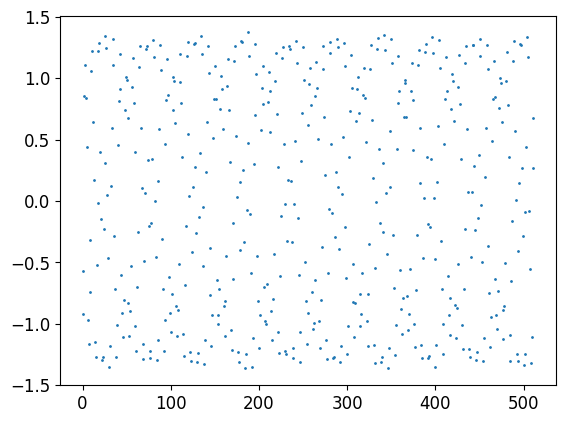

In [887]:
plt.plot(datX[:,msk,plPt], '.',ms=2);

### -- Lyapunov plots

In [420]:
nIC = 128; Nosc = Lam.shape[0]
IC = np.c_[2*np.pi*(np.random.rand(nIC,Nosc)-0.5), 10*(np.random.rand(nIC,Nosc)-0.5)]; 

# add specific points from attractor:
IC = np.r_[IC, IC_attr] 
nIC = IC.shape[0]
print(nIC)

448


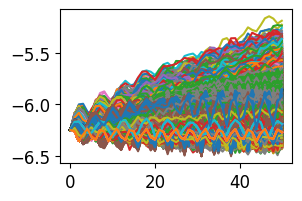

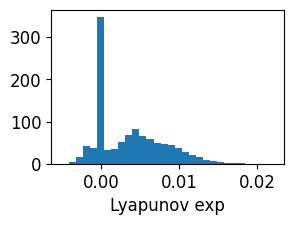

In [285]:
# evol = lambda IC, nPer: np.array(duffing_sim(IC[:,0], IC[:,1], dt, int(np.ceil(nPer*2*np.pi/omega/dt))+3, 0.01, F, omega, 0)[1])
evol = lambda IC, nSteps: np.concatenate(run_KR(max_steps=nSteps+1, IC=IC, early_stop=False,
                                n_thresh=16, n_wind=20, lyap_thresh=None, ind_lyap=False,
                                # K=6., freq=0/6, b=0.1, T=1.e-4,
                                K=0.4, freq=1/10, b=0e-3, T=0e-5, Lam=2*Lam, #K_phase=K_phase,# 5, 1/8
                               plot=False, reg_only=0)[:2], axis=2)

lyaps = np.reshape(get_lyap(evol, IC, n_wind=50, eps=1e-8), IC[:,Nosc].shape)
plt.figure(figsize=(3,2)); plt.hist(lyaps, bins=30, density=True); 
plt.xlabel('Lyapunov exp');

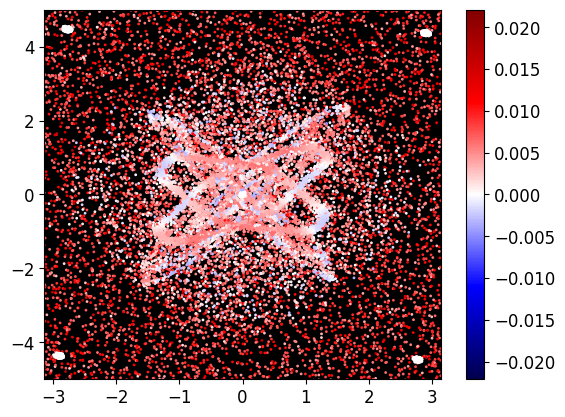

In [321]:
# plt.figure(figsize=(5,3.5))
plt.scatter(IC[:,plPt],IC[:,Nosc+plPt], c=lyaps, s=1, cmap='seismic'); 
plt.clim([-max(lyaps), max(lyaps)]); plt.gca().set_facecolor('black');
# plt.clim([-0.007,0.02])
plt.colorbar(); plt.axis(np.array([-np.pi,np.pi,-5,5]));

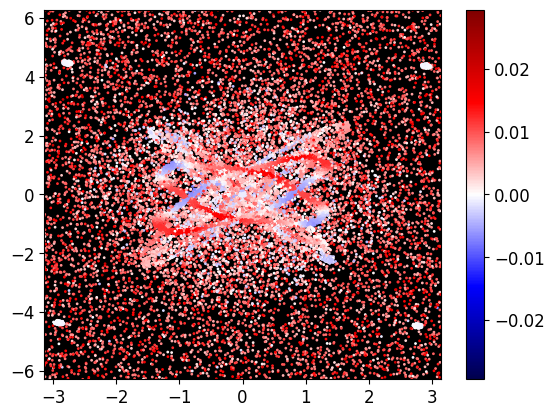

In [283]:
# plt.figure(figsize=(3,2))
plt.scatter(IC[:,plPt],IC[:,Nosc+plPt], c=lyaps, s=1, cmap='seismic'); 
# plt.clim([-max(lyaps), max(lyaps)]); plt.gca().set_facecolor('black');
# plt.clim([-0.007,0.02])
plt.colorbar(); plt.axis(np.pi*np.array([-1,1,-2,2]));

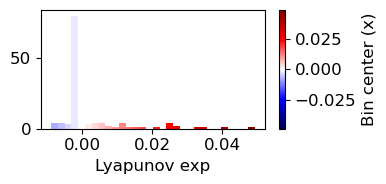

In [1149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

rng = np.random.default_rng(0)
x = rng.normal(loc=0, scale=1, size=2000)

fig, ax = plt.subplots(figsize=(4,2))
# Draw histogram but capture patches
# n, bins, patches = ax.hist(lyaps, bins=30, edgecolor='none')
n, bins, patches = ax.hist(data['lyaps'], bins=30, edgecolor='none')

# Map bin centers to colors
bin_centers = 0.5 * (bins[:-1] + bins[1:])
norm = Normalize(vmin=-bin_centers.max(), vmax=bin_centers.max())
cmap = plt.cm.seismic

for c, p in zip(bin_centers, patches):
    p.set_facecolor(cmap(norm(c)))

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Bin center (x)')
plt.xlabel('Lyapunov exp');
plt.tight_layout()
plt.show()

#### --- Different colormaps

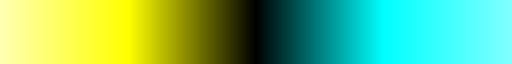

In [185]:
seismic_neg

/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_69022/917871043.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap('seismic', 256)


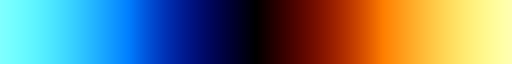

In [193]:
import matplotlib as mpl
# Get a high-res lookup table for seismic
base = cm.get_cmap('seismic', 256)
lut  = base(np.linspace(0, 1, 256))          # shape (256, 4) RGBA

# Complement RGB channels; keep alpha as-is
neg = lut.copy()
neg[:, :3] = 1.0 - neg[:, :3]

seismic_neg = colors.ListedColormap(neg, name='seismic_negative')

####################
# Build a smooth symmetric mask: 1 at ends -> 0.7 at center -> 1 at ends
u   = np.linspace(0, 1, N)               # 0..1 across colormap
d   = np.abs(u - 0.5) / 0.5              # distance from center, 1 at ends, 0 at center
ease = 0.5 - 0.5*np.cos(np.pi * d)       # smooth 0..1 as we approach ends
mask = 0. + 1 * ease                  # center=0.7, ends=1.0, smooth in between

base = seismic_neg
lut  = base(np.linspace(0, 1, N))        # RGBA
# Apply only to red and blue channels; keep green and alpha unchanged
lut_mod = lut[::-1,:].copy()
lut_mod[:, 1] *= mask                    # R channel
# lut_mod[:, 2] *= mask                    # B channel

seismic_black = colors.ListedColormap(lut_mod, name='seismic_black')

seismic_black

/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_69022/3101940630.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap('seismic', 256)


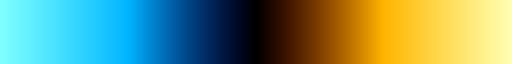

In [197]:
import matplotlib as mpl
# Get a high-res lookup table for seismic
base = cm.get_cmap('seismic', 256)
lut  = base(np.linspace(0, 1, 256))          # shape (256, 4) RGBA

# Complement RGB channels; keep alpha as-is
neg = lut.copy()
neg[:, :3] = 1.0 - neg[:, :3]

seismic_neg = colors.ListedColormap(neg, name='seismic_negative')

####################
# Build a smooth symmetric mask: 1 at ends -> 0.7 at center -> 1 at ends
u   = np.linspace(0, 1, N)               # 0..1 across colormap
d   = np.abs(u - 0.5) / 0.5              # distance from center, 1 at ends, 0 at center
# ease = 0.5 - 0.5*np.cos(np.pi * d)       # smooth 0..1 as we approach ends
mask = 0. + 1 * np.sqrt(abs(d))                 # center=0.7, ends=1.0, smooth in between

base = seismic_neg
lut  = base(np.linspace(0, 1, N))        # RGBA
# Apply only to red and blue channels; keep green and alpha unchanged
lut_mod = lut[::-1,:].copy()
lut_mod[:, 1] *= mask                    # R channel
# lut_mod[:, 2] *= mask                    # B channel

seismic_black1 = colors.ListedColormap(lut_mod, name='seismic_black1')

seismic_black1

/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_69022/3023851127.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap('seismic', N)


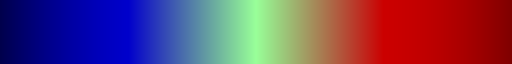

In [153]:
from matplotlib import cm, colors

# Sample seismic at high resolution
N = 512
base = cm.get_cmap('seismic', N)
lut  = base(np.linspace(0, 1, N))        # RGBA

# Build a smooth symmetric mask: 1 at ends -> 0.7 at center -> 1 at ends
u   = np.linspace(0, 1, N)               # 0..1 across colormap
d   = np.abs(u - 0.5) / 0.5              # distance from center, 1 at ends, 0 at center
ease = 0.5 - 0.5*np.cos(np.pi * d)       # smooth 0..1 as we approach ends
mask = 0.6 + 0.4 * ease                  # center=0.7, ends=1.0, smooth in between

# Apply only to red and blue channels; keep green and alpha unchanged
lut_mod = lut.copy()
lut_mod[:, 0] *= mask                    # R channel
lut_mod[:, 2] *= mask                    # B channel

seismic_green = colors.ListedColormap(lut_mod, name='seismic_rb_dimmed')

seismic_green

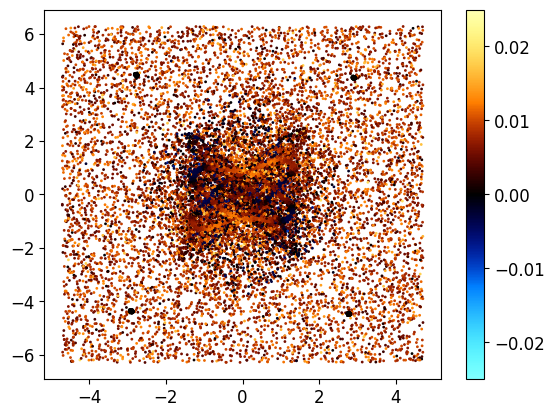

In [218]:
# plt.figure(figsize=(3,2))
plt.scatter(IC[:,plPt],IC[:,Nosc+plPt], c=lyaps, s=1, cmap=seismic_black);#_green); 
plt.clim([-max(lyaps), max(lyaps)]); plt.colorbar(); #plt.gca().set_facecolor('black');

### -- Compute fractal dimension

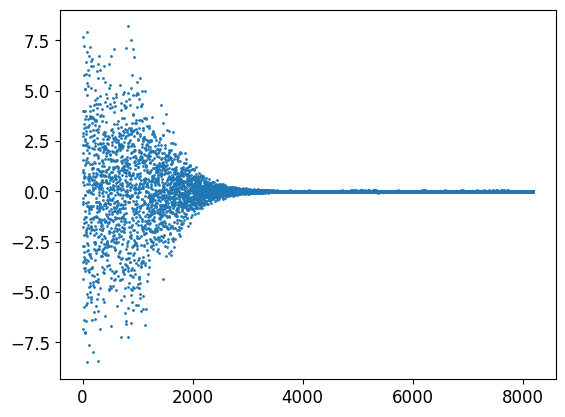

In [231]:
plIC = 0; plPt=0
plt.plot(th[:,plIC,plPt], '.', ms=2);

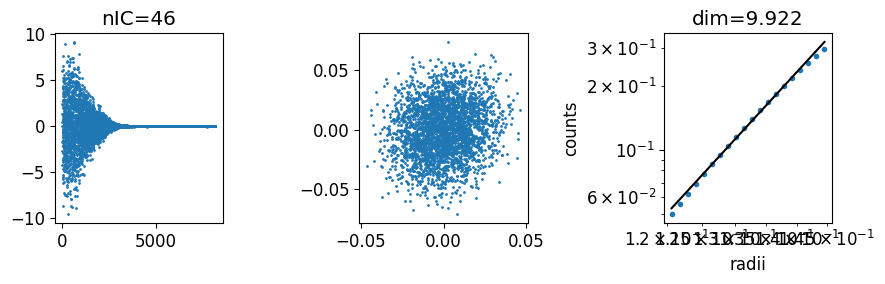

In [225]:
import numpy as np
from scipy.spatial.distance import pdist

def corr_dimension(X, radii=[5,30], theiler=None, fit_slice=slice(2,-2)):
    """
    X: (N, D) array of points
    radii: optional array of radii; or lower and upper percentile of all pairwise dist
    theiler: optional exclusion window for time series indices
    fit_slice: which radii indices to use for linear fit in log-log space
    """
    N = X.shape[0]

    # Compute condensed pairwise distances (length = N*(N-1)/2)
    d = pdist(X, metric='euclidean')  # float64 condensed vector

    # Optional Theiler window: mask distances for |i-j| <= theiler
    if theiler is not None and theiler > 0:
        # Build mask for condensed indices efficiently
        # Map (i,j) with i<j to index k = i*N - i*(i+1)//2 + (j - i - 1)
        # Construct row/col indices without full NxN memory
        rows = []
        cols = []
        # Chunked build to avoid huge arrays for very large N
        for i in range(N-1):
            j_start = i + 1
            j_end = N
            j = np.arange(j_start, j_end, dtype=np.int64)
            rows.append(np.full_like(j, i))
            cols.append(j)
        row = np.concatenate(rows)
        col = np.concatenate(cols)
        k = row * N - (row * (row + 1)) // 2 + (col - row - 1)
        mask = np.abs(row - col) > theiler
        d = d[mask]

    # Choose radii if not provided
    if len(radii)==2:
        dd = d[d > 0]
        lo, hi = np.percentile(dd, [radii[0], radii[1]])
        radii = np.exp(np.linspace(np.log(lo), np.log(hi), 20))

    # Sort distances once
    d_sorted = np.sort(d)
    M = len(d_sorted)

    # For each r, count number of pairs with distance <= r by binary search
    from bisect import bisect_right
    counts = np.fromiter((bisect_right(d_sorted, r) for r in radii), dtype=np.int64)

    # Correlation sum and slope fit
    C = (2.0 * counts) / (N * (N - 1))
    x = np.log(radii)
    y = np.log(C)
    sl = fit_slice
    coef = np.polyfit(x[sl], y[sl], 1)
    return coef, dict(radii=radii, C=C, slope_window=(sl.start, sl.stop))


def plot_attractor(th,v, plIC, tStart=0, plPt=0, radii=[5,30]):
    Xc = np.c_[th[tStart:,plIC,:], v[tStart:,plIC,:]];
    coef, dat = corr_dimension(Xc, theiler=5, radii=radii)

    plt.figure(figsize=(9,3))
    plt.subplot(131)
    plt.plot(th[:,plIC,plPt], '.',ms=2); plt.title(f'nIC={plIC}')
    plt.subplot(132)
    plt.plot(th[tStart:,plIC,plPt], v[tStart:,plIC,plPt],'.',ms=2)
    plt.subplot(133)
    plt.loglog(dat['radii'], dat['C'],'.')
    plt.loglog(dat['radii'], np.exp(coef[1])*(dat['radii']**coef[0]),'k-');
    plt.xlabel('radii'); plt.ylabel('counts'); #plt.xticks(rotation=60)
    plt.title(f'dim={coef[0]:.4g}')
    plt.tight_layout()
    plt.show()
    
# tStart = 4000; #round(0.5*th.shape[0])
plot_attractor(th,v,plIC=46,tStart=5000, radii=[5,30])
# plot_attractor(np.random.randn(*th.shape),np.random.randn(*v.shape),plIC=28,tStart=5000) # max dim - for calibration

In [243]:
# Save this specicifi data to plot attractors:
import pickle
with open("KHN16_attractor1.pkl", "wb") as file:
    pickle.dump({'th': th, 'v': v, 'plIC': plIC}, file)

In [247]:
# Load data:
import pickle
# Open the file in binary read mode ('rb')
with open("KHN16_attractor0.pkl", "rb") as file:
    data_ld = pickle.load(file)

print("Loaded dictionary:", data_ld.keys())

Loaded dictionary: dict_keys(['th', 'v', 'plIC'])


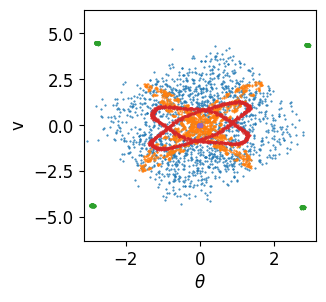

In [241]:
plt.figure(figsize=(3,3))
# plt.subplot(131) # th dim are (max_steps, nIC, Nosc)
plPt=0; plIC = [32, 98, 38, 207, 0]; plSt=3000;
plSt=round(0.8*th.shape[0]); 
plt.plot(th[plSt:,plIC,plPt], v[plSt:,plIC,plPt], '.', ms=1); plt.axis(np.pi*np.array([-1,1,-2,2]))
plt.xlabel(r"$\theta$"); plt.ylabel('v');

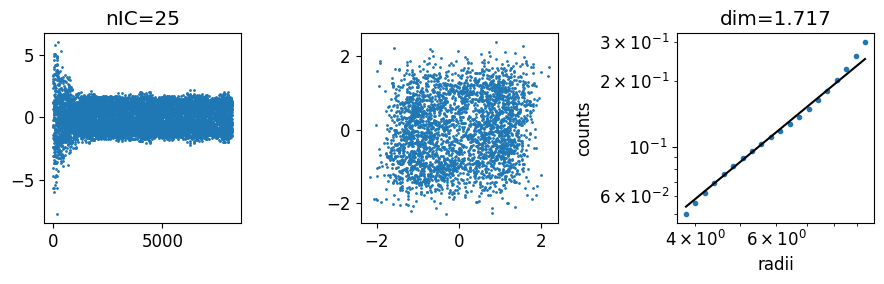

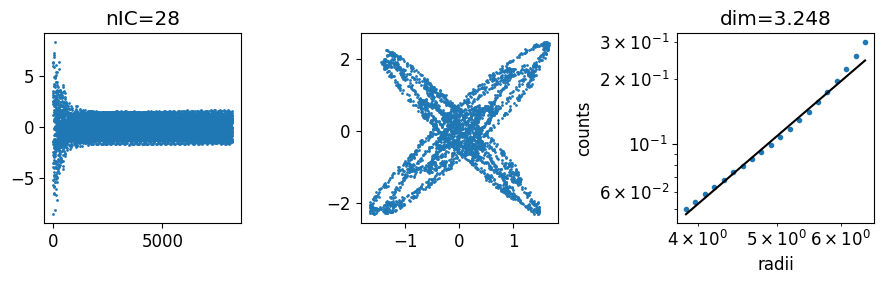

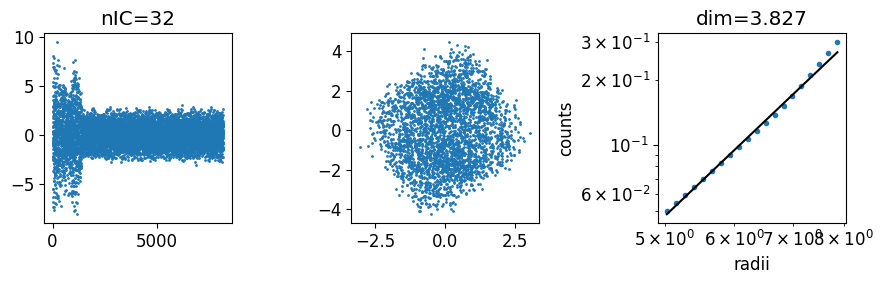

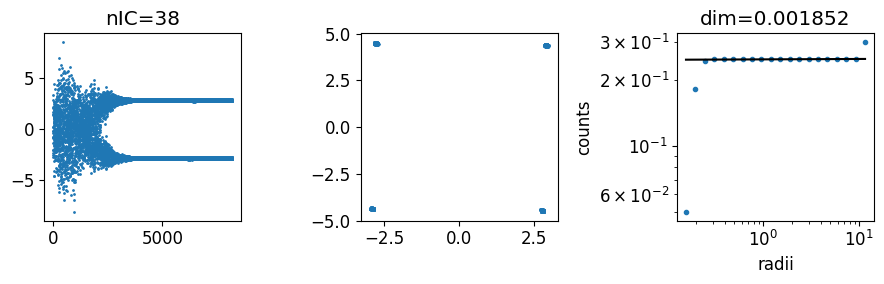

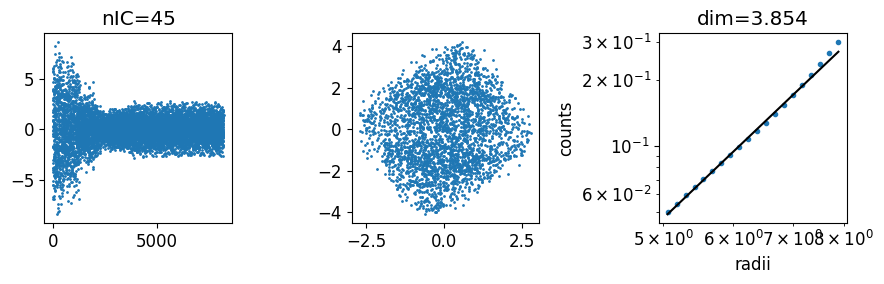

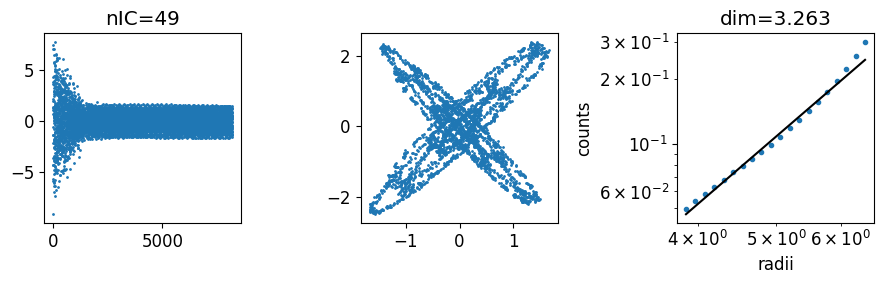

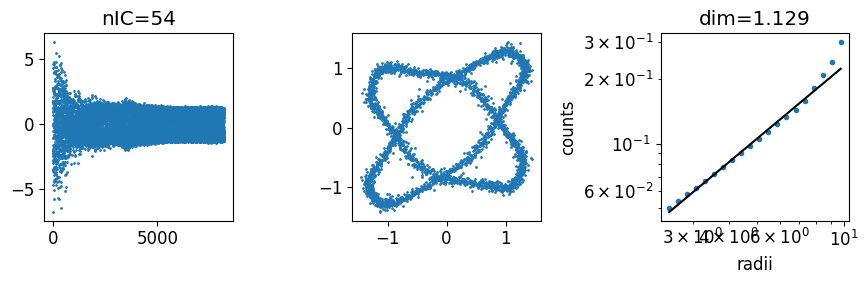

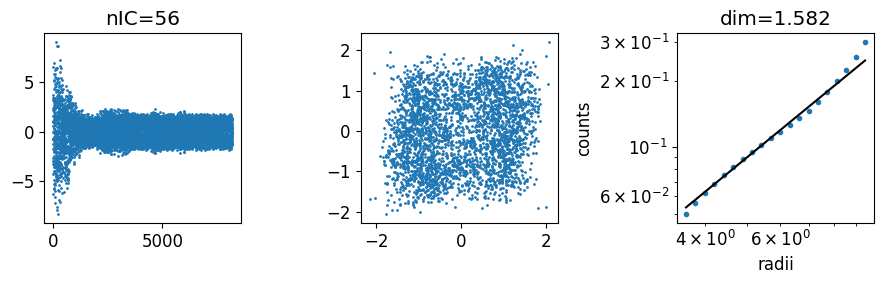

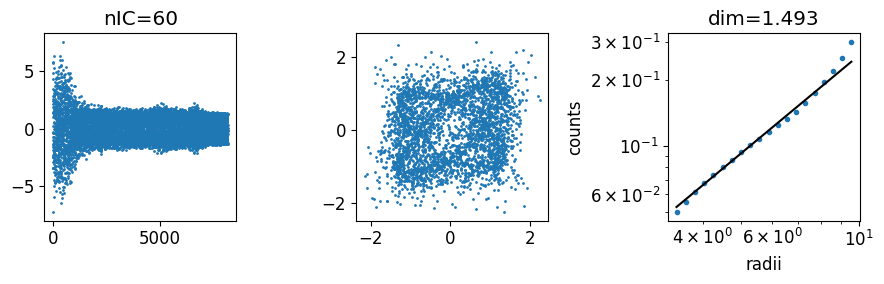

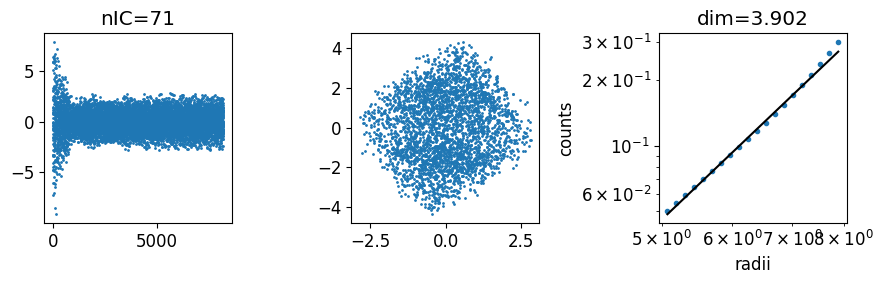

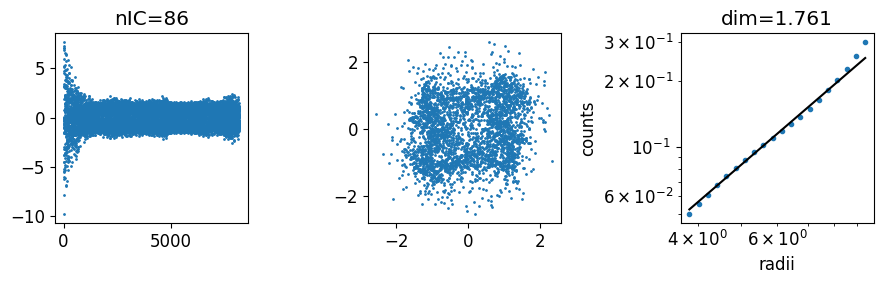

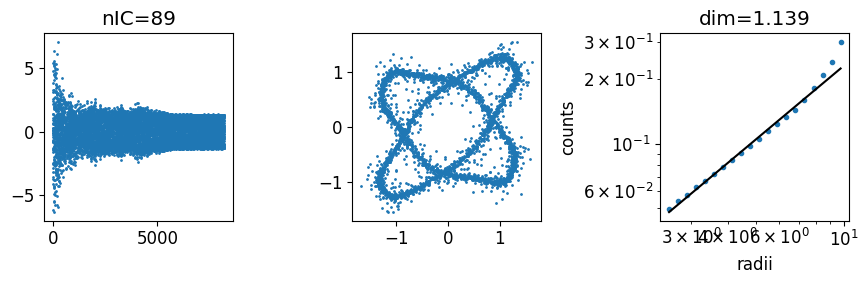

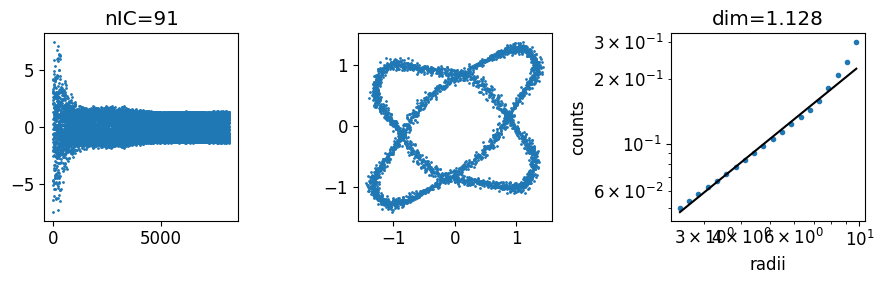

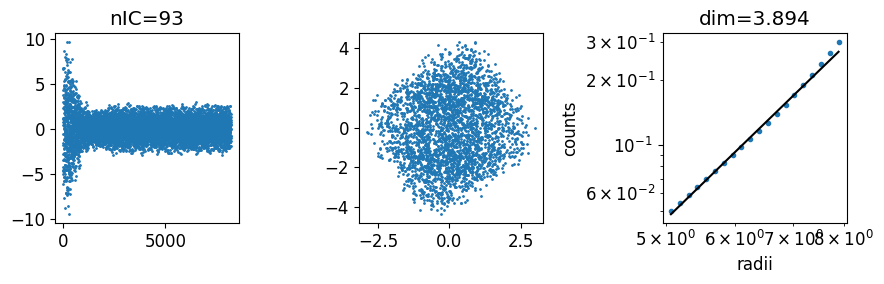

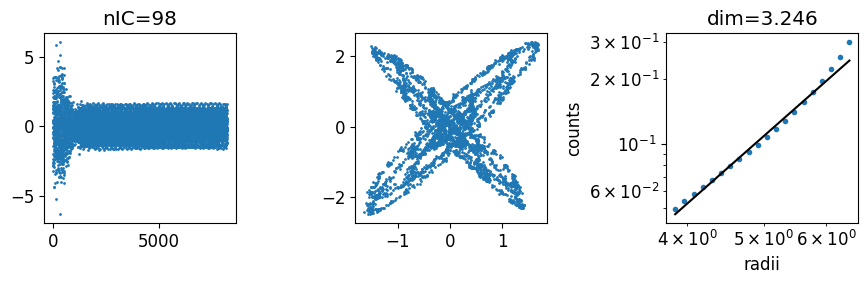

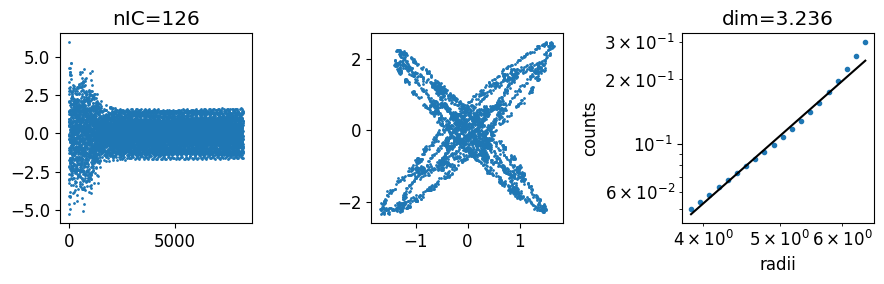

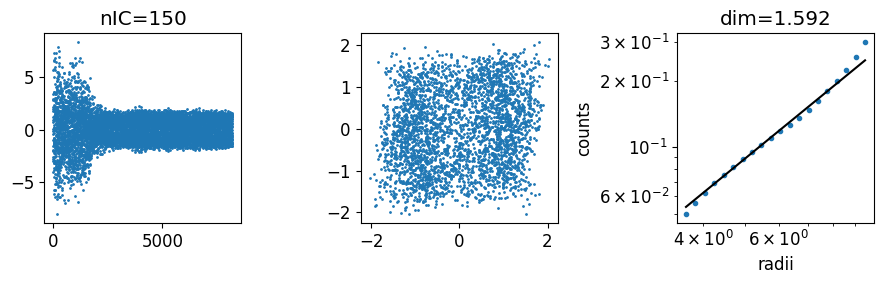

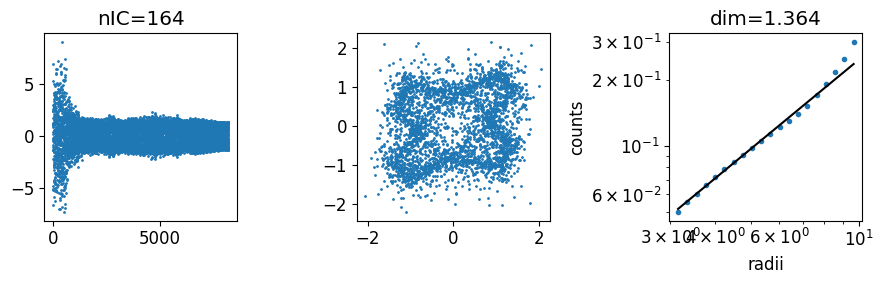

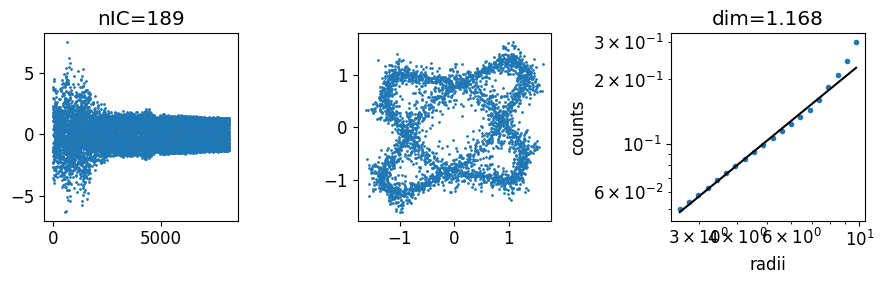

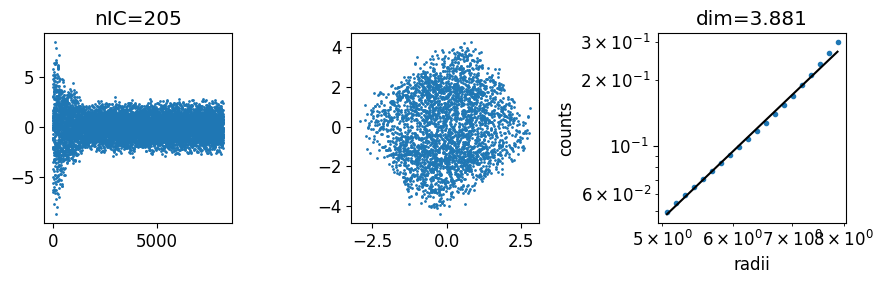

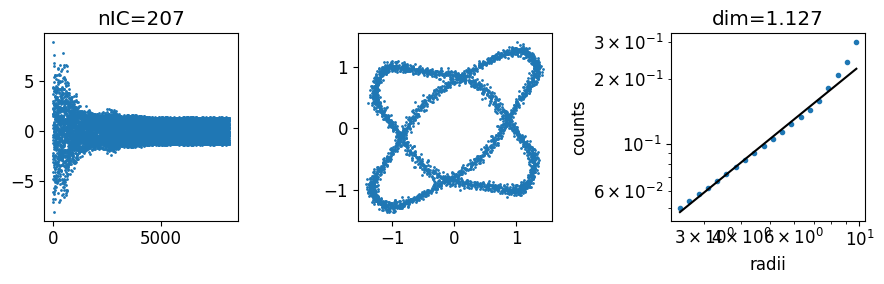

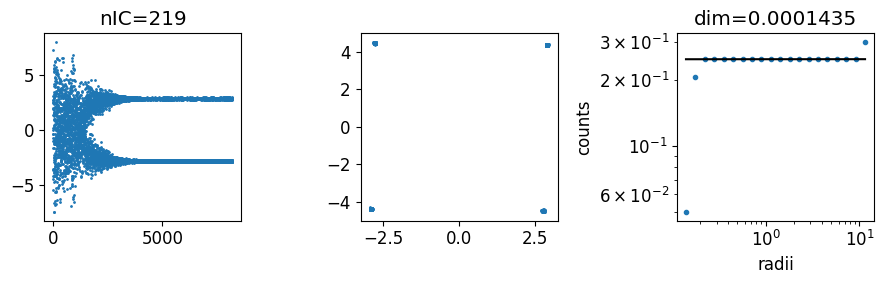

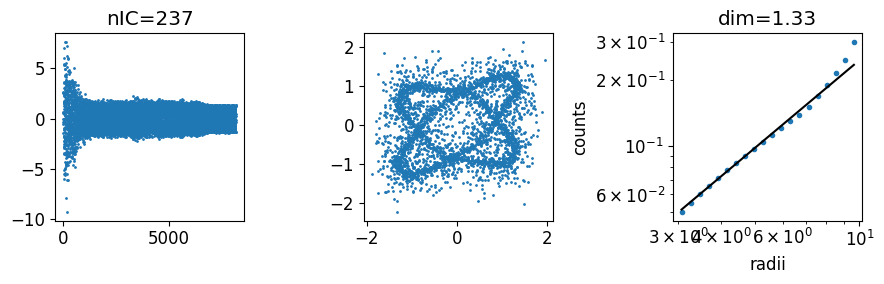

IndexError: index 256 is out of bounds for axis 1 with size 256

In [227]:
# Loop over attractors:
tStart=5000
ii=0; plIC=0;
while ii<25:
  if np.max(np.abs(th[tStart:,plIC,0]))<0.3: 
    plIC+=1;
    continue
  plot_attractor(th,v,plIC,tStart, radii=[5,30])
  ii+=1; plIC+=1;

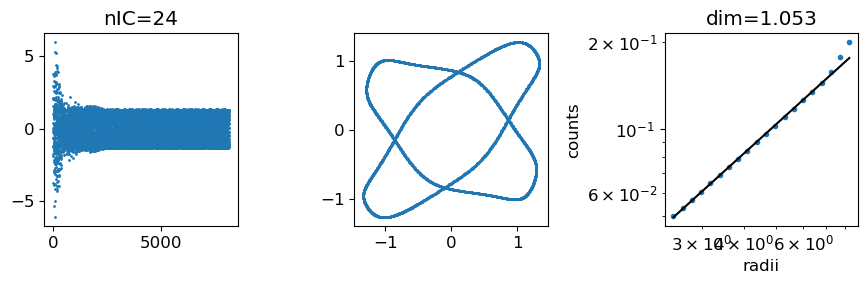

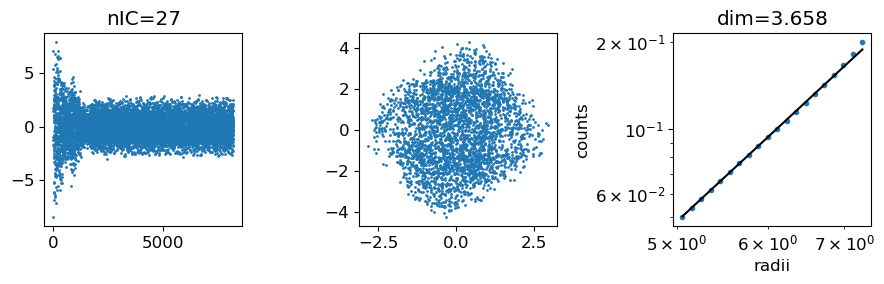

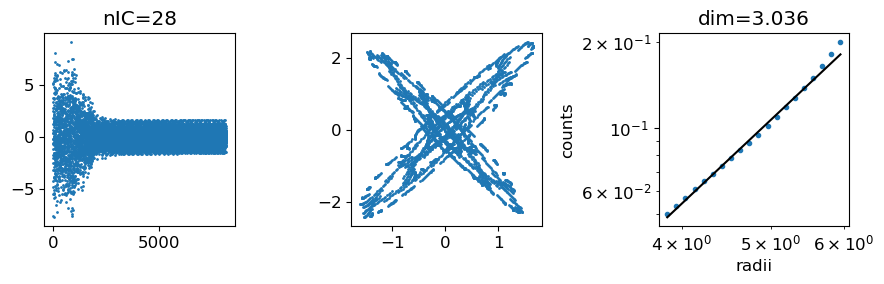

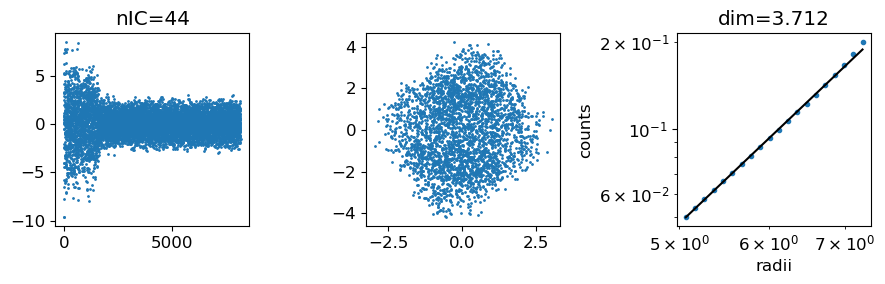

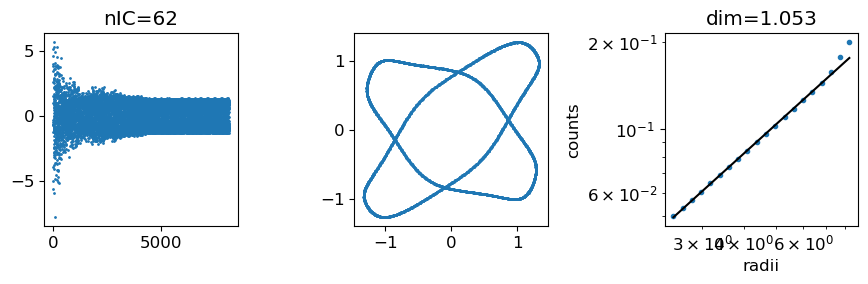

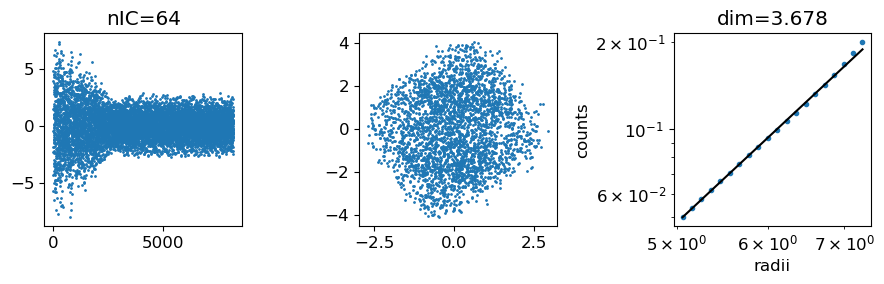

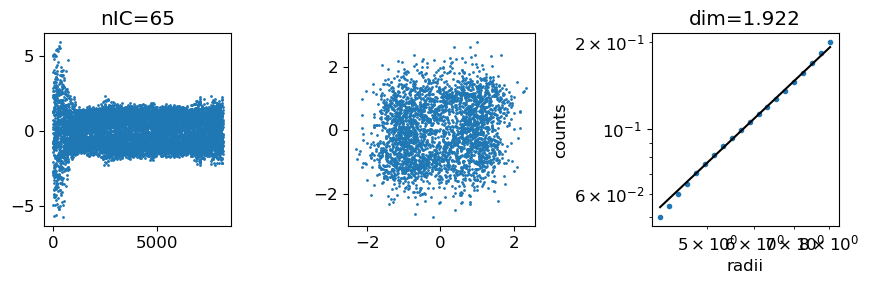

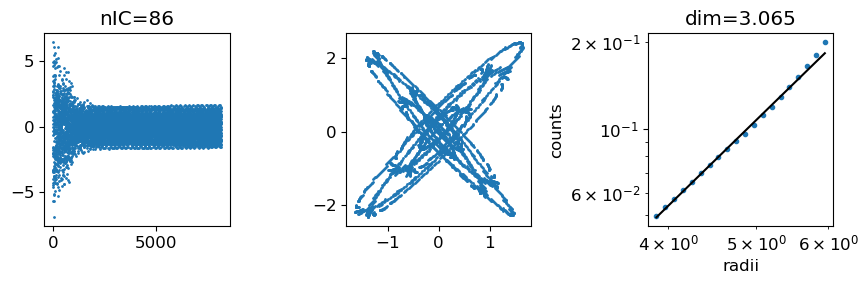

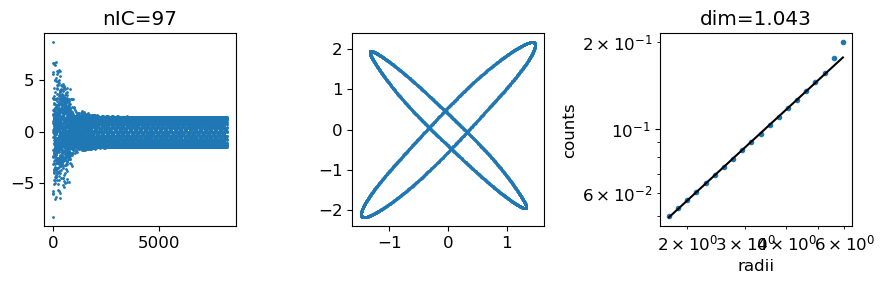

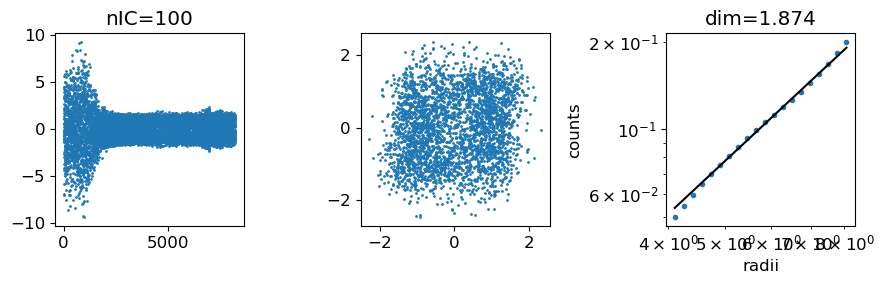

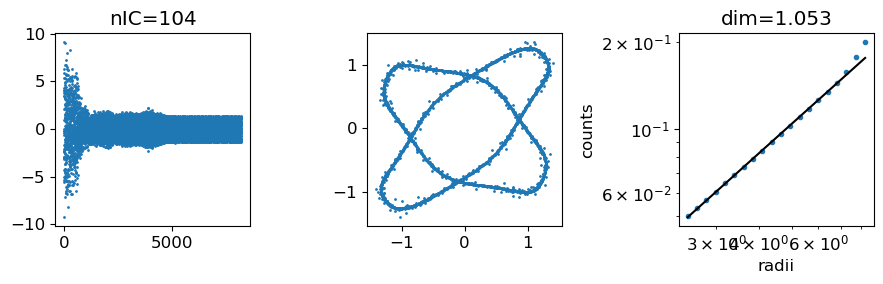

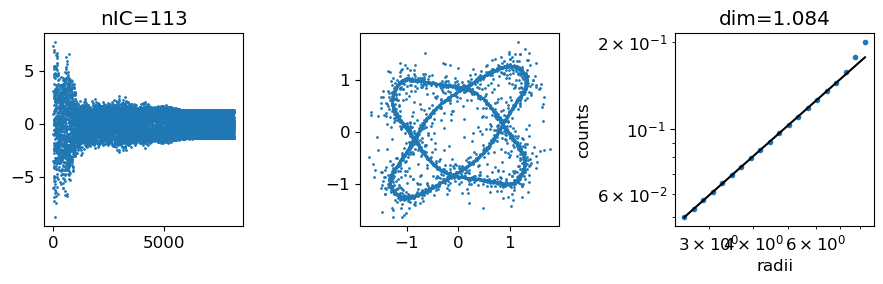

IndexError: index 128 is out of bounds for axis 1 with size 128

In [708]:
# Loop over attractors:
tStart=5000
ii=0; plIC=0;
while ii<25:
  if np.max(np.abs(th[tStart:,plIC,0]))<0.3: 
    plIC+=1;
    continue
  plot_attractor(th,v,plIC,tStart)
  ii+=1; plIC+=1;

## - Run basic system simulation

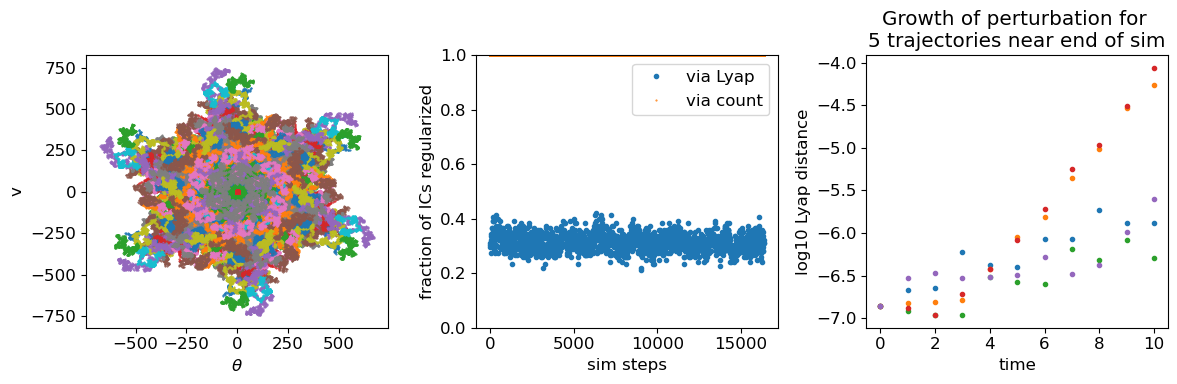

CPU times: user 3.77 s, sys: 197 ms, total: 3.97 s
Wall time: 5.11 s


(None, None)

In [998]:
%%time
th,v,reg_frac,ord_par = run_KR(max_steps=16*1024, nIC=128, early_stop=False,
                                n_thresh=16, n_wind=10, lyap_thresh=0.3, ind_lyap=False,
                                K=3., freq=1/6, b=0., T=1.e-4,
                                # K=3, freq=1/10, b=1e-1, T=0., Lam=Lam, # 5, 1/8
                               plot=True,)
regularization_time(reg_frac, plot=True)
# plt.xlim(0,200)

## -Nice Plots

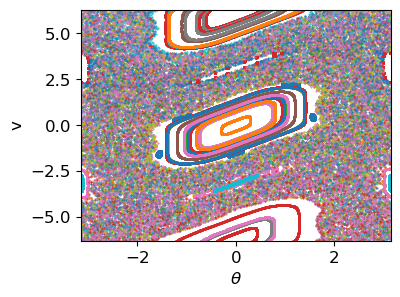

In [883]:
plSt = round(0.7*th.shape[0]); plPt=0; 
plt.figure(figsize=(4,3.))
plt.plot(th[plSt:,:,plPt], v[plSt:,:,plPt], '.', ms=1); plt.axis(np.pi*np.array([-1,1,-2,2]))
plt.xlabel(r"$\theta$"); plt.ylabel('v');

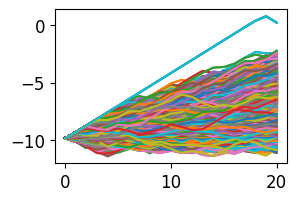

In [652]:
# Local Lyapunov exponents ############
rng = 2*np.pi*np.array([-1/2,1/2,-1,1])
X,Y = np.meshgrid(np.linspace(rng[0], rng[1], 90), np.linspace(rng[2], rng[3], 92));
IC = np.c_[X.flatten(), Y.flatten()]

evol = lambda IC, nPer: np.concatenate(run_KR(max_steps=nPer+1, IC=IC, early_stop=False,
                                n_thresh=16, n_wind=20, lyap_thresh=None, ind_lyap=False,
                                K=2., freq=0/6, b=0., T=1.e-4,
                                # K=3, freq=1/10, b=1e-1, T=0., Lam=Lam, # 5, 1/8
                               plot=False,)[:2], axis=2)
lyaps1 = np.reshape(get_lyap(evol, IC, n_wind=20, eps=1e-10), X.shape)

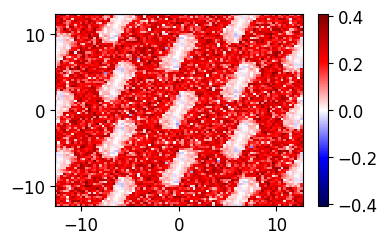

In [461]:
plt.figure(figsize=(4,2.5))
plt.pcolormesh(X,Y, lyaps1,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps1),np.max(lyaps1)])

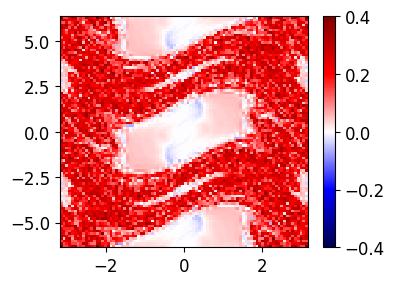

In [660]:
plt.figure(figsize=(4,3.))
plt.pcolormesh(X,Y, lyaps1,cmap='seismic'); 
plt.clim([-0.4,0.4])
# plt.clim([-np.max(lyaps),np.max(lyaps)]); #plt.axis(np.pi*np.array([-1,1,-2,2]))
plt.colorbar(); 

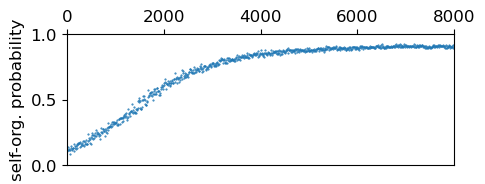

In [3284]:
plt.figure(figsize=(5,1.7))
plt.plot(reg_frac,'.',ms=1);
plt.ylim([0,1]); plt.xlim([0,8000]);
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
# plt.xlabel("simulation time-steps");
plt.ylabel("self-org. probability");
# plt.tight_layout()

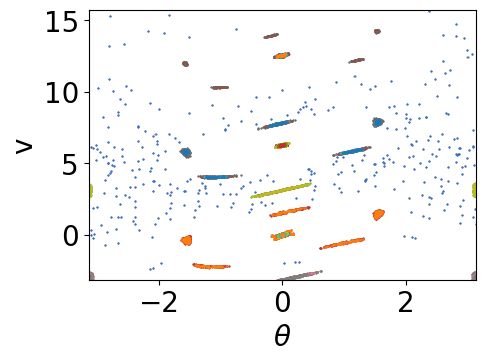

In [3190]:
plt.figure(figsize=(5,3.5))
plPt=0;
plt.rcParams.update({'font.size': 20})
plSt=round(5800); plEd=-1; plt.plot(th[plSt:plEd,:,plPt], v[plSt:plEd,:,plPt], '.', ms=1); 
plt.axis(1*np.pi*np.array([-1,1,-1,5])); #plt.ylim(-4*np.pi, 2*np.pi); plt.xlim(-2*np.pi, 2*np.pi);
# plt.axis([0,0.02,-0.2,-0.1])
plt.xlabel(r"$\theta$"); plt.ylabel('v');
plt.show()

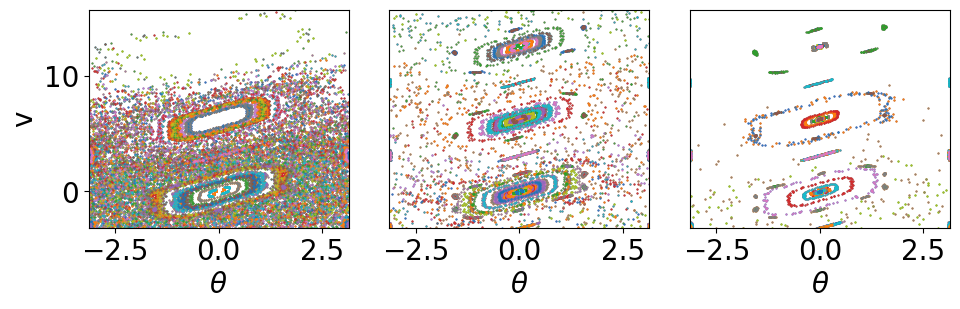

In [3294]:
# relaxation dynamics
plt.figure(figsize=(10,3.5))
plPt=0;
plt.rcParams.update({'font.size': 20})
tSt=2500; tLen=100;
for ipl in range(3):
  ax=plt.subplot(1,3,ipl+1)
  plSt=round(tSt*ipl); plEd=plSt+tLen; plt.plot(th[plSt:plEd,:,plPt], v[plSt:plEd,:,plPt], '.', ms=1); 
  plt.axis(1*np.pi*np.array([-1,1,-1,5])); #plt.ylim(-4*np.pi, 2*np.pi); plt.xlim(-2*np.pi, 2*np.pi);
  # plt.axis([0,0.02,-0.2,-0.1])
  plt.xlabel(r"$\theta$"); 
  if ipl==0: plt.ylabel('v');
  else: ax.get_yaxis().set_ticks([])
plt.tight_layout(); 
plt.show()

In [2912]:
th[plSt:,:,plPt[0]].shape

(196, 256)

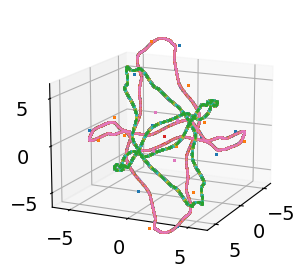

In [184]:
######## 3D Plot ###########
# plt.figure(figsize=(3,3))
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(3,3))
ax.view_init(elev=15., azim=25) #ax.view_init(elev=15., azim=25)

plPt=(0,1,2);
plSt=round(200); 
datX,datY,datZ = th[plSt:,:,plPt[0]], th[plSt:,:,plPt[1]], v[plSt:,:,plPt[1]]
ax_lim=2*np.pi*np.array([-1,1,-1,1,-1,1])
msk=np.full(datX.shape,True)
# msk=(ax_lim[0]<datX) & (datX<ax_lim[1]) & (ax_lim[2]<datY) & (datY<ax_lim[3]) & (ax_lim[4]<datZ) & (datZ<ax_lim[5]) 
# plt.rcParams.update({'font.size': 22})
for nic in range(th.shape[1]):
  ax.plot(datX[msk[:,nic],nic],datY[msk[:,nic],nic],datZ[msk[:,nic],nic], '.', ms=1)#, alpha=0.1); 
# plt.ylim(-2*np.pi, 2*np.pi); plt.xlim(-3*np.pi, 3*np.pi);
plt.axis(ax_lim)
# plt.xlabel(r"$\theta_1$"); plt.ylabel(r"$\theta_2$"); ax.set_zlabel(r"$\theta_3$")
plt.tight_layout()
plt.show()

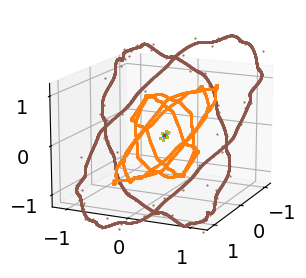

In [215]:
######## 3D Plot ###########
# plt.figure(figsize=(3,3))
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(3,3))
ax.view_init(elev=15., azim=25) #ax.view_init(elev=15., azim=25)

plPt=(0,1,2);
plSt=round(200); 
datX,datY,datZ = th[plSt:,:,plPt[0]], th[plSt:,:,plPt[1]], v[plSt:,:,plPt[1]]
ax_lim=1.2*np.array([-1,1,-1,1,-1,1])
msk=np.full(datX.shape,True)
# msk=(ax_lim[0]<datX) & (datX<ax_lim[1]) & (ax_lim[2]<datY) & (datY<ax_lim[3]) & (ax_lim[4]<datZ) & (datZ<ax_lim[5]) 
# plt.rcParams.update({'font.size': 22})
for nic in range(th.shape[1]):
  ax.plot(datX[msk[:,nic],nic],datY[msk[:,nic],nic],datZ[msk[:,nic],nic], '.', ms=1)#, alpha=0.1); 
# plt.ylim(-2*np.pi, 2*np.pi); plt.xlim(-3*np.pi, 3*np.pi);
plt.axis(ax_lim)
# plt.xlabel(r"$\theta_1$"); plt.ylabel(r"$\theta_2$"); ax.set_zlabel(r"$\theta_3$")
plt.tight_layout()
plt.show()

In [ ]:
if subplot is None: fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    else: ax = plt.gcf().add_subplot(subplot[0],subplot[1],subplot[2],projection='3d')
    # else: ax.set_box_aspect([1,1,1])
    ax.plot_surface(xDom[:,None], yDom[None,:], -surf, cmap=plt.cm.coolwarm, zorder=0)#, vmin=-0.,vmax=0.8)#, linewidth=0, antialiased=True)
    # plt.pcolormesh(xDom, yDom, V2(xDom[:,None], yDom[None,:]), cmap=plt.cm.coolwarm); #plt.cm.PiYG
    # plt.clim([-0.8,0.]); plt.colorbar();
    ax.axis([min(xDom),max(xDom),min(yDom),max(yDom),-0.1,0.8]); #ax.set_zlim([-0.1,0.8]); 
    ax.view_init(elev=35., azim=35)
    ax.plot(loc[0], loc[1], -Vgen(loc[None,:]),'k.', markersize=8, zorder=8)

Interesting parameters:
* 2-particle KHN: K=3, freq=1/4.682, b=5e-1, T=0e-2, Lam=Lam, => chaotic attractors
* also same parameters for 4x4 2D grid
* K=3, freq=1/3, b=5e-1, T=0e-2, Lam=Lam16_rnd, - many regular small orbits
* K=1.5, freq=1/10, b=1e-1, T=0e-3, Lam=2*Lam16_rnd_loose, - pretty knot 

## - $\eta$: reg timescale vs b

In [1051]:
np.linspace(3e-2,0.5,20)

array([0.03      , 0.05473684, 0.07947368, 0.10421053, 0.12894737,
       0.15368421, 0.17842105, 0.20315789, 0.22789474, 0.25263158,
       0.27736842, 0.30210526, 0.32684211, 0.35157895, 0.37631579,
       0.40105263, 0.42578947, 0.45052632, 0.47526316, 0.5       ])

In [984]:
%%time
### Get b-dependence of reg timescale ########
p_arr = np.geomspace(5e-4,9e-2,20)[::-1] # b variation
# p_arr = np.geomspace(5e-3,15e-2,20)[::-1] # b variation
# p_arr = np.geomspace(4e-2, 5e-2, 10)[::-1]
# p_arr = 0.5e-1+np.linspace(0, 1e-1, 9)[::-1] # b variation
# p_arr = np.linspace(3e-2,5e-1,21)[::-1] # b variation
nfitpar=2
fit_pars=np.nan*np.zeros((len(p_arr),nfitpar)); cov=np.nan*np.zeros((len(p_arr),nfitpar,nfitpar)); fin_frac=np.nan*np.zeros(len(p_arr));
for ip,p in enumerate(tqdm(p_arr)):
  th,v,reg_frac,_ = run_KR(max_steps=4*8*1024, nIC=128, 
                           n_thresh=16, n_wind=10, lyap_thresh=0.,
                           K=2, freq=0, b=p, T=0,
                           # K=6.4, freq=1/15, b=p, T=0e-5, Lam=Lam2, 
                           # K=4, freq=1/10, b=p, T=0e-5, Lam=Lam,
                           # K=1., freq=1/10, b=p, T=1e-4, Lam=2*Lam,
                           plot=False)
  fin_frac[ip] = reg_frac[np.isfinite(reg_frac)][-1];
  a,b = regularization_time(reg_frac, plot=False)
  if a is None: break # no longer able to regularize
  fit_pars[ip,:],cov[ip,:,:],=a,b
print('Finished')

 65%|██████▌   | 13/20 [03:30<01:53, 16.22s/it]

Finished
CPU times: user 1min 28s, sys: 46.1 s, total: 2min 14s
Wall time: 3min 30s


In [1140]:
np.c_[p_arr,fit_pars]

array([[ 5.00000000e-01,  6.06263746e+02,  5.57893636e-03],
       [ 4.76500000e-01,  7.22372882e+02,  4.38001699e-02],
       [ 4.53000000e-01,  1.13137880e+03,  1.40283520e-02],
       [ 4.29500000e-01,  1.49071409e+03,  1.08174183e-01],
       [ 4.06000000e-01,  2.10923454e+03, -9.11271299e-02],
       [ 3.82500000e-01,  2.70397774e+03,  9.72512044e-03],
       [ 3.59000000e-01,  5.85872884e+03, -1.76318431e-01],
       [ 3.35500000e-01,  2.64070771e+04, -4.89678148e-01],
       [ 3.12000000e-01,  6.42321410e+04, -3.65010063e-01],
       [ 2.88500000e-01,             nan,             nan],
       [ 2.65000000e-01,             nan,             nan],
       [ 2.41500000e-01,             nan,             nan],
       [ 2.18000000e-01,             nan,             nan],
       [ 1.94500000e-01,             nan,             nan],
       [ 1.71000000e-01,             nan,             nan],
       [ 1.47500000e-01,             nan,             nan],
       [ 1.24000000e-01,             nan

/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_69022/604374450.py:12: RuntimeWarning: invalid value encountered in log
  msk=msk & np.isfinite(np.log(fit_pars[:,0]))# & (col<0.5);


[ -6.59227632 -18.09732704] [3.32857127]


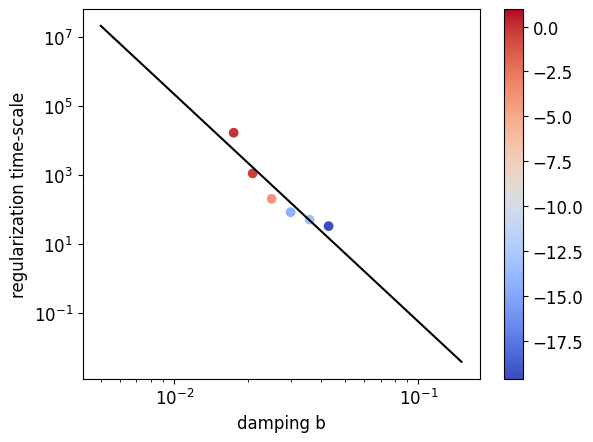

In [986]:
# plt.plot(b_arr, fit_pars[:,0],'.'); 
# msk = (np.abs(fit_pars[:,1])>1e-1) | (fit_pars[:,2]<0.8); plt.plot(b_arr[msk], fit_pars[msk,0],'r.'); # mark less reliable fits
# col = fin_frac; msk=np.isfinite(cov[:,0,0]) & (col>0.);
col = (1-np.exp(fit_pars[:,1])); # ~(fraction of IC that are regular)
msk=np.isfinite(cov[:,0,0]);# & np.isfinite(col)#(np.abs(col)<1);
plt.scatter(p_arr[msk], fit_pars[msk,0], c=col[msk], cmap=plt.cm.coolwarm); plt.colorbar(); #plt.clim([None,0])#clim=np.max(np.abs(col[msk])); plt.clim(-clim,clim); 
# plt.errorbar(b_arr[msk], fit_pars[msk,0], yerr=100*np.sqrt(cov[msk,0,0])) #errors too small to see
plt.xscale('log'); plt.yscale('log'); 
plt.xlabel('damping b'); plt.ylabel('regularization time-scale');
# plt.axis('scaled');#'equal', adjustable='box');
# Linear fit:
msk=msk & np.isfinite(np.log(fit_pars[:,0]))# & (col<0.5); 
lfit,res, _,_,_=np.polyfit(np.log(p_arr[msk]), np.log(fit_pars[msk,0]), deg=1, full=True)#, w=rem_frac[msk])
plt.plot(p_arr, p_arr**(lfit[0])*np.exp(lfit[1]),'k')
print(lfit, res)

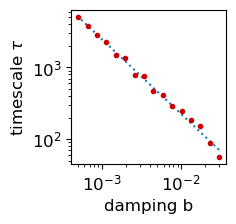

In [3439]:
plt.figure(figsize=(2.,2.))
plt.plot(p_arr[msk], p_arr[msk]**(lfit[0])*np.exp(lfit[1]),':')
plt.plot(p_arr[msk], fit_pars[msk,0], '.', color=[0.8,0,0])#c=col[msk], cmap=plt.cm.coolwarm); plt.colorbar(); #plt.clim([None,0])#clim=np.max(np.abs(col[msk])); plt.clim(-clim,clim); 
# plt.errorbar(b_arr[msk], fit_pars[msk,0], yerr=100*np.sqrt(cov[msk,0,0])) #errors too small to see
plt.xscale('log'); plt.yscale('log'); #plt.xlim([None,])
plt.xlabel('damping b'); plt.ylabel(r"timescale $\tau$");

## - $\epsilon$: area fraction of reg islands

In [475]:
%%time
##### Get K-dependence of reg island size #####
# p_arr = [0.9,1,1.5,3]#7,7.1,7.2,7.3,7.4]#np.linspace(1.5,15,50)[::-1]
# p_arr=[5]
# p_arr=K_arr
p_arr= 6.75-np.geomspace(1e-1,4,25)
p_arr = np.linspace(5,6.6,50)[::-1]
# p_arr=6.53-np.geomspace(1e-2,1.9,10)
# p_arr = 6.75-np.geomspace(1e-2,4,15)
# p_arr = K_arr#(ldDat[:,0])
# p_arr = np.geomspace(1e-2,3e-1,10)[::-1] # b variation
# p_arr = np.geomspace(2e-2, 2e-1, 10) # T variation
nfitpar=2
fit_pars=np.nan*np.zeros((len(p_arr),nfitpar)); cov=np.nan*np.zeros((len(p_arr),nfitpar,nfitpar)); fin_frac=np.nan*np.zeros(len(p_arr));
for ip,p in enumerate(tqdm(p_arr)):
  th,v,reg_frac,_ = run_KR(max_steps=32, nIC=1024*8*124, 
                           n_thresh=15, n_wind=20, #lyap_thresh=0.2,
                           K=p, freq=0/np.pi, b=0, T=0,
                           # K=p, freq=1/15, b=0e-1, T=0e-5, Lam=Lam2,
                           # K=p, freq=1/6, b=0e-1, T=0e-5, Lam=2*Lam,
                           # K=p, freq=1/10, b=0e-1, T=0e-5, Lam=Lam,
                           plot=False)
  fin_frac[ip] = reg_frac[np.isfinite(reg_frac)][-1];
  # a,b = regularization_time(reg_frac, plot=False)
  # if a is None: break # no longer able to regularize
  # fit_pars[ip,:],cov[ip,:,:],=a,b
print('Finished')
print(fin_frac)
isl_frac=fin_frac

100%|██████████| 50/50 [14:38<00:00, 17.57s/it]

Finished
[0.00103169 0.00091848 0.00126008 0.00164401 0.002404   0.00293166
 0.00249752 0.00202597 0.00158199 0.00226421 0.00284503 0.00308424
 0.00285389 0.00287259 0.00353216 0.00329885 0.0035932  0.00388656
 0.00387573 0.00358926 0.00323585 0.00213426 0.00226618 0.00190686
 0.00166567 0.00148749 0.00155443 0.00143039 0.00177199 0.0020368
 0.00317186 0.00300647 0.00307834 0.00220908 0.003922   0.0074965
 0.00783416 0.00340616 0.00497929 0.0034347  0.00249653 0.00238529
 0.00289129 0.00634864 0.01011018 0.01191268 0.01432259 0.01118814
 0.00834508 0.00513778]
CPU times: user 10min 34s, sys: 2min 31s, total: 13min 5s
Wall time: 14min 38s


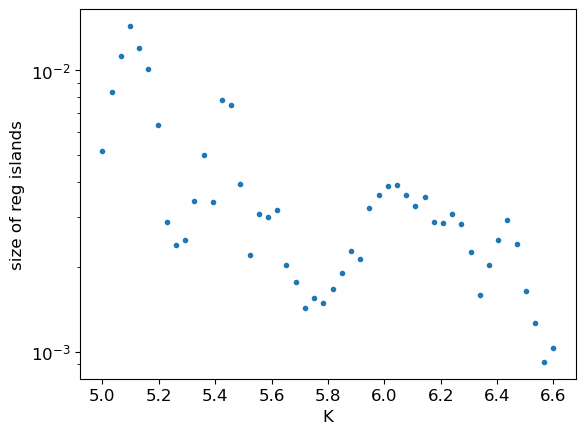

In [509]:
plt.plot(p_arr, isl_frac,'.'); plt.yscale('log'); #plt.xscale('log');
plt.ylabel('size of reg islands'); plt.xlabel('K'); #plt.axis('scaled');

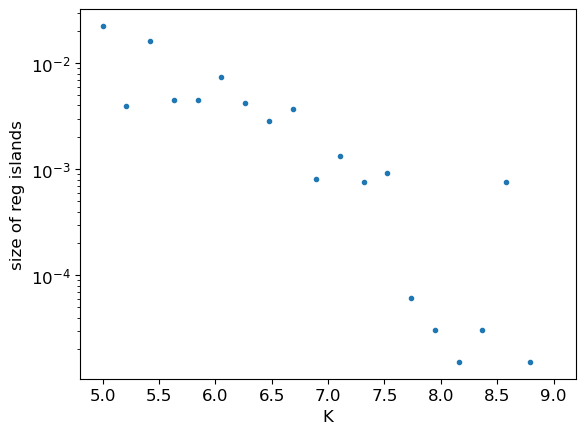

In [1248]:
plt.plot(p_arr, isl_frac,'.'); plt.yscale('log'); #plt.xscale('log');
plt.ylabel('size of reg islands'); plt.xlabel('K'); #plt.axis('scaled');

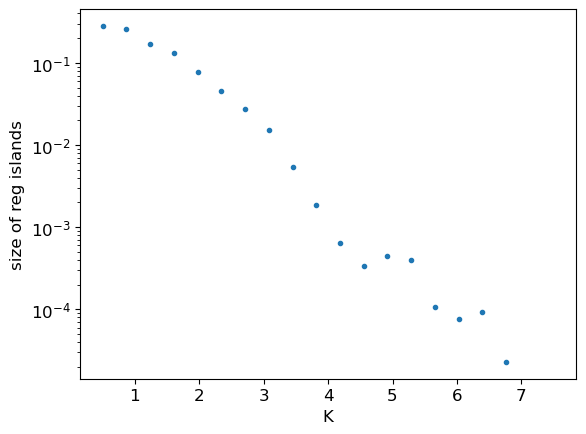

In [608]:
plt.plot(p_arr, isl_frac,'.'); plt.yscale('log'); #plt.xscale('log');
plt.ylabel('size of reg islands'); plt.xlabel('K'); #plt.axis('scaled');

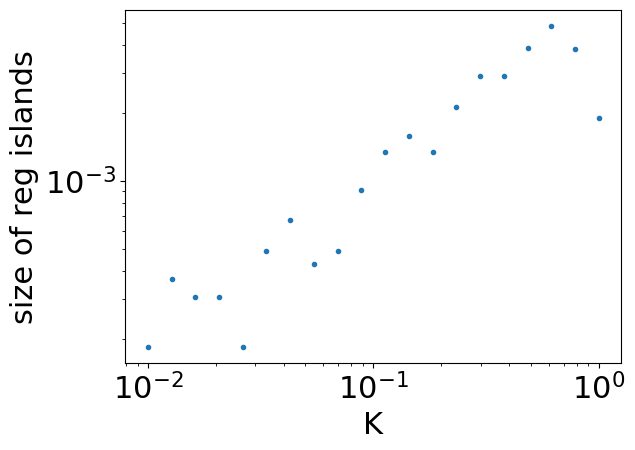

In [142]:
plt.plot(6.75-p_arr, fin_frac,'.'); plt.yscale('log'); plt.xscale('log');
plt.ylabel('size of reg islands'); plt.xlabel('K'); plt.axis('scaled');

## - $\eta$ vs $\epsilon$

In [75]:
params = dict(freq=0, T=0e-5,
              # freq=1/np.pi, T=0e-5, #Lam=Lam2,
             # freq=1/15, T=0e-5, Lam=Lam2,
             plot=False)

In [681]:
params = dict(freq=0, T=0e-5,
              # freq=1/np.pi, T=0e-5, #Lam=Lam2,
             # freq=1/15, T=0e-5, Lam=Lam2,
             plot=False)
K_arr = 6.75-np.geomspace(1e-2,5,30) # best for plain KR
# K_arr = 6.75-np.geomspace(5e-2,0.5,10)
# K_arr = 6.75-np.geomspace(5e-1,5,10)
# K_arr = np.r_[3,4,5,np.linspace(5.5,6.4,5)][::-1]
K_arr = np.linspace(5,6.6,50)[::-1]
# K_arr = np.linspace(6.2,6.4,5)[::-1]
# K_arr = 6.5-np.geomspace(1e-1,3.5,10) # best for Lam2
# K_arr = np.linspace(5,10,10)[::-1] # for web map f=1/6
# K_arr = np.linspace(1.5,10,10) # for web map f=1/pi
K_arr

array([6.6       , 6.56734694, 6.53469388, 6.50204082, 6.46938776,
       6.43673469, 6.40408163, 6.37142857, 6.33877551, 6.30612245,
       6.27346939, 6.24081633, 6.20816327, 6.1755102 , 6.14285714,
       6.11020408, 6.07755102, 6.04489796, 6.0122449 , 5.97959184,
       5.94693878, 5.91428571, 5.88163265, 5.84897959, 5.81632653,
       5.78367347, 5.75102041, 5.71836735, 5.68571429, 5.65306122,
       5.62040816, 5.5877551 , 5.55510204, 5.52244898, 5.48979592,
       5.45714286, 5.4244898 , 5.39183673, 5.35918367, 5.32653061,
       5.29387755, 5.26122449, 5.22857143, 5.19591837, 5.16326531,
       5.13061224, 5.09795918, 5.06530612, 5.03265306, 5.        ])

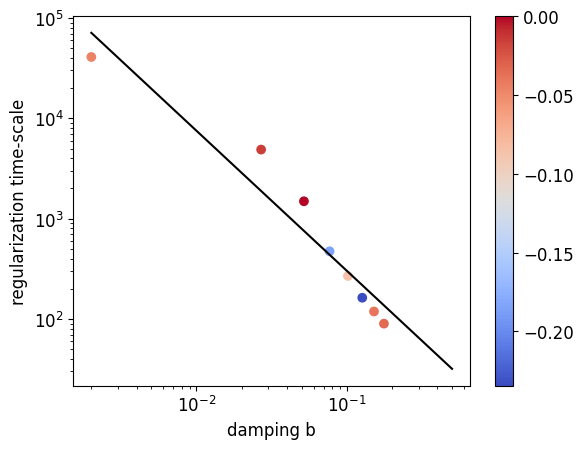

5.0 [-1.39690356  2.49240157]  time (s): 20.447173833847046
CPU times: user 20min 25s, sys: 28.2 s, total: 20min 53s
Wall time: 25min 1s


In [683]:
%%time
########## power p dep on K ###############
bt_fits=[]
t0=time.time()
for K in K_arr:#[len(bt_fits):]:
  ### Get b-dependence of reg timescale ########
  # if K >5.8: p_arr = np.geomspace(2e-1,5e-1,19)[::-1] # b variation
  # else: p_arr = np.geomspace(5e-2,3e-1,19)[::-1] # b variation
  # p_arr = np.geomspace(2e-1,5e-1,18)[::-1] 
  # if K>5: p_arr = 0.27 + np.linspace(0,1e-1,9)[::-1] 
  # else: p_arr = np.linspace(1e-1,3e-3,9)[::-1] 
  p_arr = np.linspace(2e-3,5e-1,21)[::-1] # b-var - universal!!
  # p_arr = np.r_[1e-3, 2e-3, 3e-3, np.linspace(5e-3,5e-1,19)][::-1] 
  # p_arr = np.linspace(1e-2,5e-1,30)[::-1] # b variation
  # p_arr = np.geomspace(2e-2, 2e-1, 10) # T variation
  nfitpar=2
  fit_pars=np.nan*np.zeros((len(p_arr),nfitpar)); cov=np.nan*np.zeros((len(p_arr),nfitpar,nfitpar)); fin_frac=np.nan*np.zeros(len(p_arr));
  for ip,p in enumerate(tqdm(p_arr)):
    th,v,reg_frac,_ = run_KR(max_steps=4*8*1024, nIC=128, 
                             n_thresh=16, n_wind=20, #lyap_thresh=0.1,
                             K=K, b=p, **params)
    fin_frac[ip] = reg_frac[np.isfinite(reg_frac)][-1];
    a,b = regularization_time(reg_frac, plot=False)
    if a is None: break # no longer able to regularize
    fit_pars[ip,:],cov[ip,:,:],=a,b

  # Plot b-timescale dependence:
  clear_output(wait=True)
  # plt.plot(b_arr, fit_pars[:,0],'.'); 
  # msk = (np.abs(fit_pars[:,1])>1e-1) | (fit_pars[:,2]<0.8); plt.plot(b_arr[msk], fit_pars[msk,0],'r.'); # mark less reliable fits
  # col = fin_frac; msk=np.isfinite(cov[:,0,0]) & (col>0.);
  col = (1-np.exp(fit_pars[:,1])); # ~(fraction of IC that are regular)
  msk=np.isfinite(cov[:,0,0]);# & np.isfinite(col)#(np.abs(col)<1);
  plt.scatter(p_arr[msk], fit_pars[msk,0], c=col[msk], cmap=plt.cm.coolwarm); plt.colorbar(); plt.clim([None,0])#clim=np.max(np.abs(col[msk])); plt.clim(-clim,clim); 
  # plt.errorbar(b_arr[msk], fit_pars[msk,0], yerr=100*np.sqrt(cov[msk,0,0])) #errors too small to see
  plt.xscale('log'); plt.yscale('log'); 
  plt.xlabel('damping b'); plt.ylabel('regularization time-scale');
  #plt.axis('scaled');#'equal', adjustable='box');
  # Linear fit to get tau ~ b^p power:
  msk=msk & np.isfinite(np.log(fit_pars[:,0])) & (np.abs(col)<1); 
  if sum(msk)>=3: 
    lfit, res, _,_,_=np.polyfit(np.log(p_arr[msk]), np.log(fit_pars[msk,0]), deg=1, full=True)#, w=rem_frac[msk])
    plt.plot(p_arr, p_arr**(lfit[0])*np.exp(lfit[1]),'k')
  else: lfit=np.full(2,np.nan)
  plt.show()
  t1=time.time()
  print(K, lfit,  " time (s):", t1-t0)
  t0=t1;
  bt_fits.append(np.r_[lfit,sum(msk),res])

In [711]:
np.array(bt_fits)

array([[-4.35212133,  0.80391296, 15.        ,  1.0499378 ],
       [-4.5703258 ,  0.24938295, 15.        ,  1.23979107],
       [-3.83903783,  0.96269262, 15.        ,  2.63682859],
       [-3.39685001,  1.14853597, 15.        ,  0.67437489],
       [-3.04542765,  1.58344588, 14.        ,  0.32633358],
       [-2.77951471,  1.86944748, 16.        ,  0.19099513],
       [-2.54782367,  2.1647617 , 14.        ,  0.10044922],
       [-2.55437299,  2.18321096, 16.        ,  0.23071776],
       [-2.52375199,  2.14733164, 16.        ,  0.2508302 ],
       [-2.4611645 ,  2.37674903, 16.        ,  0.25740945],
       [-2.32669014,  2.56339831, 16.        ,  0.20063638],
       [-2.29265509,  2.55857957, 18.        ,  0.45885101],
       [-2.34955658,  2.51867996, 16.        ,  0.24391235],
       [-2.28602433,  2.61298736, 18.        ,  0.23617479],
       [-2.28544526,  2.66282067, 16.        ,  0.24440508],
       [-2.41035722,  2.50280352, 18.        ,  0.31268904],
       [-2.62105072,  2.

In [713]:
fits_bck=np.c_[K_arr[:len(bt_fits)], np.array(bt_fits)]
np.savetxt("KR_bSc_v_K[5_6.6].csv", fits_bck, delimiter=",", 
           header="K, slope(p), intercept, n_points, net sum sq res")

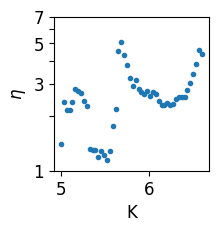

In [707]:
plt.figure(figsize=(2.,2.))
plt.plot(K_arr, -np.array(bt_fits)[:,0],'.');
plt.xlabel('K'); plt.ylabel(r'$\eta$'); plt.yscale('log')
plt.yticks([1,2,3,4,5,6,7],[1,'',3,'',5,'',7]);

100%|██████████| 50/50 [01:36<00:00,  1.94s/it]


Finished


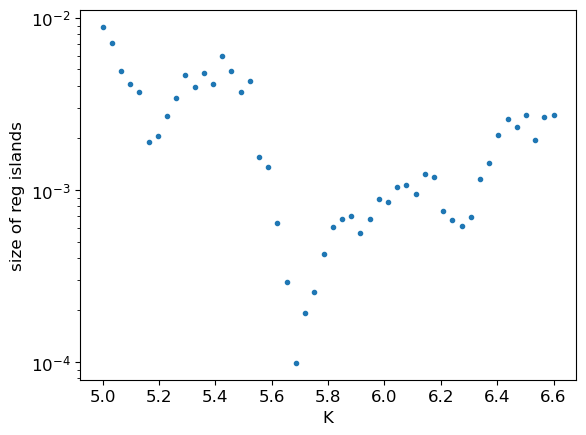

In [422]:
##### Get K-dependence of reg island size #####
nfitpar=2
fin_frac=np.nan*np.zeros(len(K_arr));
for ip,p in enumerate(tqdm(K_arr)):
  th,v,reg_frac,_ = run_KR(max_steps=32, nIC=2*124*1024, 
                           n_thresh=16, n_wind=20, lyap_thresh=0.,
                           # K=p, freq=0, b=0, T=0,
                           K=p, b=0, **params)
  fin_frac[ip] = reg_frac[np.isfinite(reg_frac)][-1];

print('Finished')
isl_frac=fin_frac

plt.plot(K_arr, fin_frac,'.'); plt.yscale('log'); #plt.xscale('log');
plt.ylabel('size of reg islands'); plt.xlabel('K'); #plt.axis('scaled');

In [80]:
fits_bck=np.c_[K_arr[:len(bt_fits)], np.array(bt_fits), isl_frac]
fits_bck

array([[ 6.65000000e+00, -4.83603253e+00,  6.70214472e-01,
         1.40000000e+01,  1.29908485e+00,  7.35375189e-04],
       [ 6.63338551e+00, -4.31125890e+00,  1.12467380e+00,
         1.50000000e+01,  4.46732392e-01,  8.93869708e-04],
       [ 6.61401062e+00, -4.23660579e+00,  1.04759177e+00,
         1.40000000e+01,  4.39626335e-01,  9.82469128e-04],
       [ 6.59141668e+00, -4.30399627e+00,  8.88743269e-01,
         1.50000000e+01,  8.40032400e-01,  9.79515814e-04],
       [ 6.56506888e+00, -4.38807810e+00,  4.31715465e-01,
         1.50000000e+01,  2.30326497e+00,  9.96251260e-04],
       [ 6.53434353e+00, -3.92803431e+00,  7.98277548e-01,
         1.50000000e+01,  2.51061941e+00,  1.27681609e-03],
       [ 6.49851331e+00, -3.45323033e+00,  1.00828546e+00,
         1.30000000e+01,  1.77493583e-01,  1.62727602e-03],
       [ 6.45673010e+00, -2.88010824e+00,  1.77426391e+00,
         1.50000000e+01,  3.56959335e-01,  2.51523910e-03],
       [ 6.40800481e+00, -2.61117224e+00,  2.102

In [88]:
msk = np.log(dat[:,4]/dat[:,3])>0
dat[msk,1] = np.nan

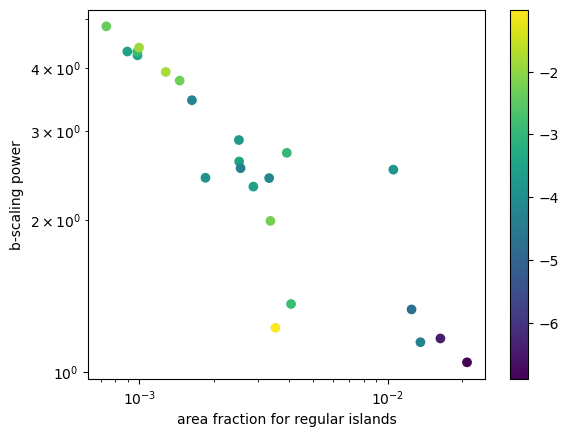

In [90]:
dat=fits_bck#[fits_bck[:,4]/fits_bck[:,3]<2]
# dat=ldDat#[(ldDat[:,4]<6) & (),:]
# plt.scatter(6.75-dat[:,0], -dat[:,1],c=dat[:,4]); plt.colorbar()
plt.scatter(dat[:,5], -dat[:,1], c=np.log(dat[:,4]/dat[:,3])); plt.colorbar()
# plt.plot(dat[:,5], -dat[:,1], '.')
plt.xscale('log'); 
plt.yscale('log')
plt.xlabel('area fraction for regular islands'); 
plt.ylabel("b-scaling power"); #plt.axis('scaled');

data columns: 
0=K, 1=slope(p), 2=intercept, 3=n_points, 4=net sum sq res, 5=isl_frac

In [1349]:
np.savetxt("KR_v2_bSc_v_K.csv", fits_bck, delimiter=",", 
           header="K, slope(p), intercept, n_points, net sum sq res, isl_frac")

In [666]:
ldDat1=np.genfromtxt("KR_v2_bSc_v_K.csv", delimiter=",", skip_header=1)

In [2276]:
K_arr=ldDat1[:,0]

/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_69022/3667859097.py:3: RuntimeWarning: divide by zero encountered in divide
  col=np.log(dat[:,4]/dat[:,3])


[-0.36389394 -1.09513883] [0.75989645]


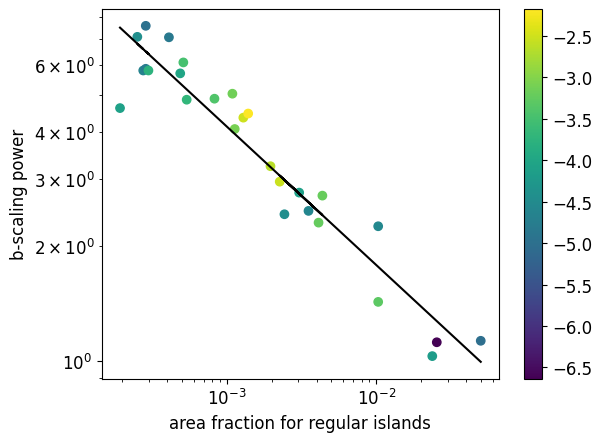

In [673]:
# dat=fits_bck[fits_bck[:,4]/fits_bck[:,3]<2]
dat=ldDat1#[(ldDat[:,4]<6) & (),:]
col=np.log(dat[:,4]/dat[:,3])
msk = col<-2
# plt.scatter(6.75-dat[:,0], -dat[:,1],c=dat[:,4]); plt.colorbar()
plt.scatter(dat[msk,5], -dat[msk,1], c=col[msk]); plt.colorbar()
plt.xlabel('area fraction for regular islands'); plt.xscale('log'); 
plt.ylabel("b-scaling power"); plt.yscale('log')

lfit,res, _,_,_=np.polyfit(np.log(dat[msk,5]), np.log(-dat[msk,1]), deg=1, full=True)#, w=rem_frac[msk])
plt.plot(dat[msk,5], dat[msk,5]**(lfit[0])*np.exp(lfit[1]),'k')
print(lfit, res)

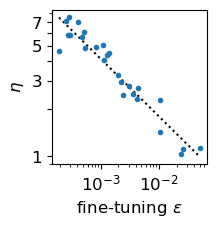

In [3426]:
plt.figure(figsize=(2,2))
plt.plot(np.sort(dat[msk,5]), np.sort(dat[msk,5])**(lfit[0])*np.exp(lfit[1]),'k:')
plt.plot(dat[msk,5], -dat[msk,1], '.')
plt.xlabel(r'fine-tuning $\epsilon$'); plt.xscale('log'); 
plt.ylabel(r"$\eta$"); plt.yscale('log') #
plt.yticks([1,2,3,4,5,6,7],[1,'',3,'',5,'',7]);

In [677]:
dat[:,0].max()

6.74

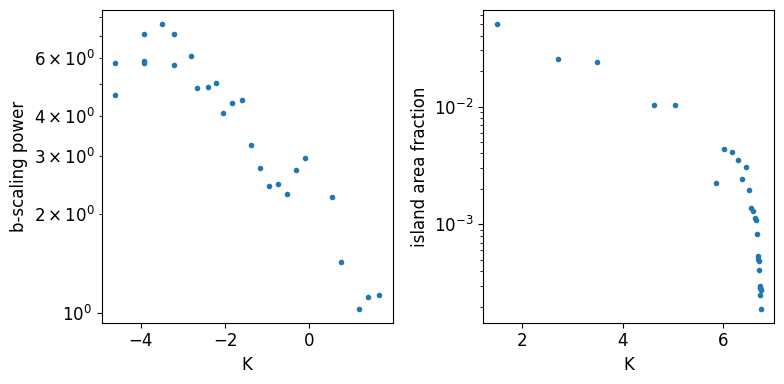

In [679]:
plt.figure(figsize=(8,4))
x_vals = dat[msk,0]#np.log10(6.75-dat[msk,0]); 
plt.subplot(121)
plt.plot(np.log(6.75-x_vals), -dat[msk,1],'.')# c=col[msk]); plt.colorbar()
plt.xlabel('K')#area fraction for regular islands'); plt.xscale('log'); 
plt.ylabel("b-scaling power"); plt.yscale('log')
plt.subplot(122)
plt.plot(x_vals, dat[msk,5],'.')#, c=col[msk]); plt.colorbar()
plt.xlabel('K')#area fraction for regular islands'); plt.xscale('log'); 
plt.ylabel("island area fraction"); plt.yscale('log')
plt.tight_layout()

## -K-T phase diagram

In [245]:
K_arr = 6.53-np.geomspace(1e-2,1.5,10)
K_arr

array([6.52      , 6.5125503 , 6.4995508 , 6.47686707, 6.43728464,
       6.3682145 , 6.24768919, 6.03737616, 5.67038627, 5.03      ])

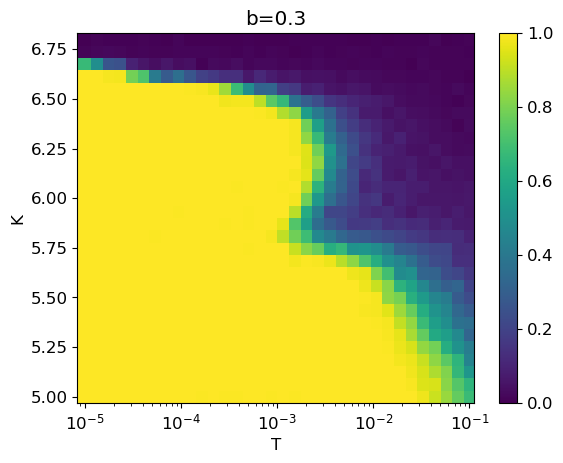

100%|██████████| 30/30 [1:44:54<00:00, 209.81s/it]

Finished
CPU times: user 1h 59s, sys: 7min 19s, total: 1h 8min 19s
Wall time: 1h 44min 54s


In [65]:
%%time
### Get b-dependence of reg timescale ########
K_arr = np.linspace(5,6.8,30)
T_arr = np.geomspace(1e-5,1e-1,34)
# K_arr = np.linspace(6.25,6.65,30)
# T_arr = np.linspace(1e-6,1e-3,34)

# K_arr = np.linspace(6.5,6.575,10)
# K_arr = 6.53-np.geomspace(1e-2,1.5,15)
# T_arr = np.geomspace(1e-6,1e-1,34)
b_arr = [0.3]


# b_arr = np.geomspace(7e-2,3e-1,4)[::-1] # K=6.5
# T_arr = np.geomspace(1e-5,5e-2,14)

# b_arr = np.geomspace(1e-2,1e-1,4)[::-1] # K=5
# T_arr = np.geomspace(1e-3,0.3,45)

# b_arr = np.geomspace(1e-3,1e-1,4)[::-1] # K=3
# T_arr = np.geomspace(1e-3,1,15)

# b_arr = np.geomspace(5e-2,3e-1,4)[::-1] # KHN2, K=3, f=0.1
# T_arr = np.geomspace(5e-2,5,14)
# b_arr = np.geomspace(9e-2,2e-1,4)[::-1] # KHN2, K=4, f=0.1
# T_arr = np.geomspace(1e-2,1,14)
# b_arr = np.geomspace(2e-1,5e-1,4)[::-1] # KHN4, K=5, f=0.1
# T_arr = np.geomspace(1e-3,5e-1,14)
nfitpar=2
# fit_pars=np.nan*np.zeros((len(p_arr),nfitpar)); cov=np.nan*np.zeros((len(p_arr),nfitpar,nfitpar)); 
fin_frac=np.nan*np.zeros((len(b_arr),len(K_arr),len(T_arr)));
for ib,b in enumerate(b_arr):
  print('b=',b)
  for iK,K in enumerate(tqdm(K_arr)):
    # if iK>=12: break
    for iT,T in enumerate((T_arr)):
      th,v,reg_frac,_ = run_KR(max_steps=4*16*1024, nIC=64, #early_stop=False,
                               n_thresh=16, n_wind=10, lyap_thresh=0.3,
                               K=K, freq=0, b=b, T=T,
                               # K=6.4, freq=1/15, b=p, T=0e-5, Lam=Lam2, 
                               # K=4, freq=1/10, b=b, T=T, Lam=Lam,
                               plot=False)
      fin_frac[ib,iK,iT] = np.mean(reg_frac[np.isfinite(reg_frac)][-10:]);
      # a,b = regularization_time(reg_frac, plot=False)
      # if a is None: break # no longer able to regularize
    # fit_pars[ip,:],cov[ip,:,:],=a,b

    clear_output(wait=True)
    plt.pcolormesh(T_arr, K_arr, fin_frac[ib,:,:])
    plt.xscale('log'); 
    plt.clim([0,1]); plt.colorbar()
    plt.xlabel('T'); plt.ylabel('K');
    plt.title(f"b={b}")
    plt.show();
print('Finished')

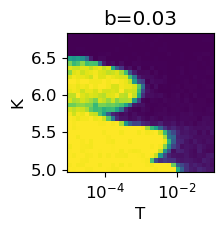

In [151]:
plt.figure(figsize=(1.9,1.8))
ib=0
plt.pcolormesh(T_arr, K_arr, fin_frac_bck2[ib,:,:])
plt.xscale('log'); plt.xticks([1e-4,1e-2])
# plt.clim([0,1]); plt.colorbar()
plt.xlabel('T'); plt.ylabel('K');
plt.title(f"b={b_arr[ib]}")
plt.show();

In [83]:
import pickle
with open(r"KT_phase_diagr_new.pkl", "wb") as output_file:
  pickle.dump(fin_frac, output_file)

In [139]:
import pickle
with open(r"KT_phase_diagr_new.pkl", "rb") as input_file:
  fin_frac = pickle.load(input_file)
K_arr = np.linspace(5,6.8,30)
T_arr = np.geomspace(1e-5,1e-1,34)

In [15]:
fin_frac.shape

(2, 30, 34)

In [19]:
fin_frac_bck1 = np.zeros((3,30,34))
fin_frac_bck1[0] = fin_frac_bck[0]
fin_frac_bck1[2] = fin_frac_bck[1]
fin_frac_bck1[1] = fin_frac

Text(0.5, 1.0, 'b=0.1')

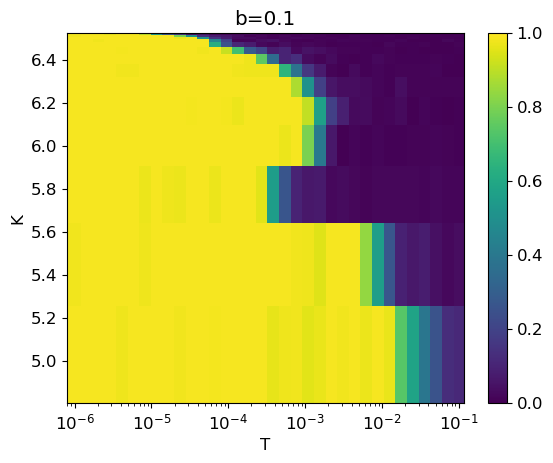

In [261]:
plt.pcolormesh(T_arr, K_arr, fin_frac[ib,:,:]) #T_arr, K_arr, 
plt.xscale('log'); 
plt.clim([0,1]); plt.colorbar()
plt.xlabel('T'); plt.ylabel('K');
plt.title(f"b={b}")

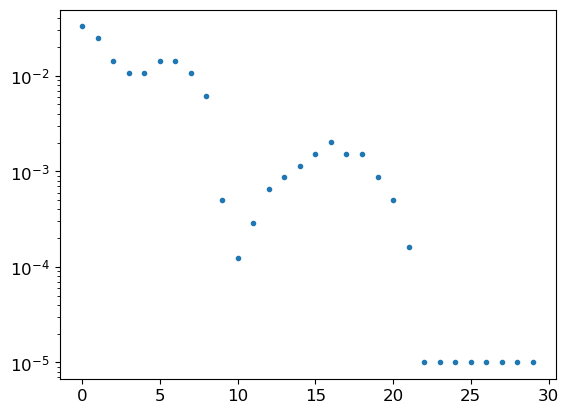

In [187]:
plt.plot(T_arr[np.argmax(fin_frac[0]<0.5,axis=1)],'.')
plt.yscale('log');

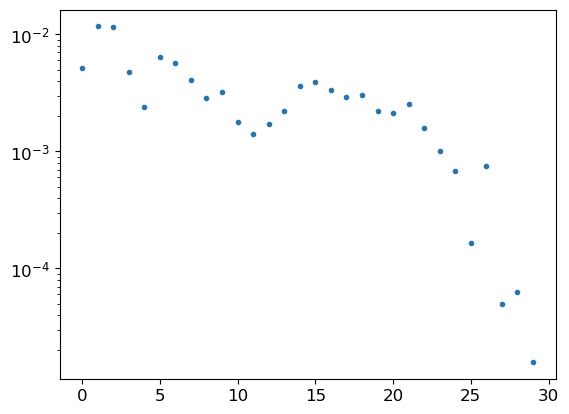

In [209]:
plt.plot(isl_frac, '.'); plt.yscale('log');

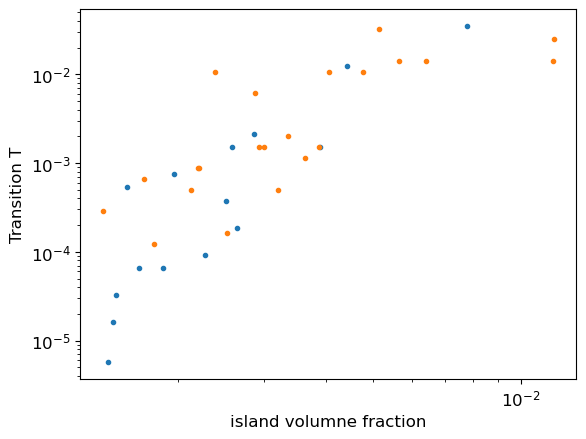

In [298]:
trans_idx = np.argmax(fin_frac[0]<0.5,axis=1)
T_trans = T_arr[trans_idx]; #T_trans[trans_idx==0]=np.nan
plt.loglog(isl_frac, T_trans, '.'); #plt.yscale('log');
plt.loglog(isl_frac_bck, [T_arr_bck[i] if i>0 else np.nan for i in np.argmax(fin_frac_bck[0]<0.5,axis=1)], '.');
# plt.axis('equal')
plt.xlabel('island volumne fraction'); plt.ylabel('Transition T');

In [255]:
fin_frac=fin_frac_bck1

In [251]:
fin_frac_bck1=fin_frac.copy()

In [217]:
isl_frac_bck = isl_frac.copy()

In [263]:
T_arr_bck = np.geomspace(1e-5,1e-1,34)

(0.0, 1.0)

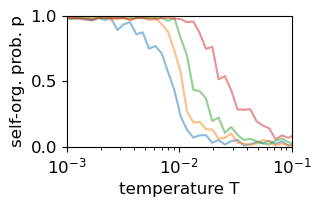

In [3529]:
# plt.figure(figsize=(4,2.5))
plt.figure(figsize=(2.9,1.7))
plt.plot(T_arr, fin_frac[::-1,:].T,'-',label=b_arr[::-1], alpha=0.5); plt.xscale('log'); #plt.yscale('log')
plt.ylabel('self-org. prob. p'); plt.xlabel('temperature T'); plt.xlim([1e-3,1e-1]); plt.ylim([0,1])
# plt.legend(["b=0.1", "b=0.05", "b=0.02", "b=0.01"][::-1]);

## - $\gamma$: reg fraction vs T

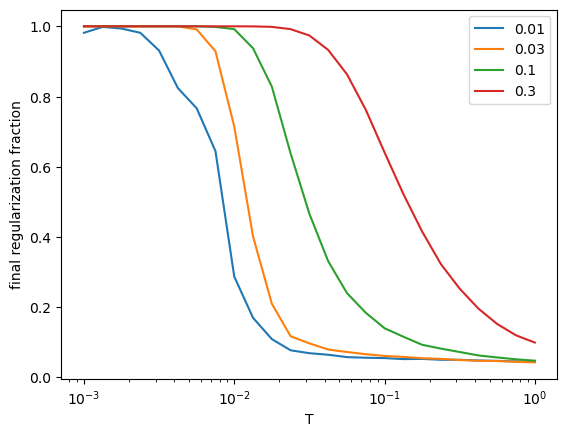

Finished
CPU times: user 9min 44s, sys: 40.9 s, total: 10min 24s
Wall time: 11min 34s


In [19]:
%%time
### Get b-dependence of reg timescale ########
# b_arr = np.geomspace(7e-2,3e-1,4)[::-1] # K=6.5
# T_arr = np.geomspace(1e-5,5e-2,14)

b_arr = np.geomspace(1e-2,1e-1,4)[::-1] # K=5
T_arr = np.geomspace(1e-3,0.3,45)

# b_arr = [0.03]#, 0.1]#, 0.3] #
# T_arr = np.geomspace(1e-4,4e-2,25)
b_arr = [0.01,0.03,0.1,0.3]#, 0.1]#, 0.3] #
T_arr = np.geomspace(1e-3,10e-1,25)

# b_arr = np.geomspace(1e-3,1e-1,4)[::-1] # K=3
# T_arr = np.geomspace(1e-3,1,15)

# b_arr = np.geomspace(5e-2,3e-1,4)[::-1] # KHN2, K=3, f=0.1
# T_arr = np.geomspace(5e-2,5,14)
# b_arr = np.geomspace(9e-2,2e-1,4)[::-1] # KHN2, K=4, f=0.1
# T_arr = np.geomspace(1e-2,1,14)
# b_arr = np.geomspace(2e-1,5e-1,4)[::-1] # KHN4, K=5, f=0.1
# T_arr = np.geomspace(1e-3,5e-1,14)
nfitpar=2
# fit_pars=np.nan*np.zeros((len(p_arr),nfitpar)); cov=np.nan*np.zeros((len(p_arr),nfitpar,nfitpar)); 
fin_frac=np.nan*np.zeros((len(b_arr),len(T_arr)));
for ib,b in enumerate((b_arr)):
  for iT,T in enumerate(tqdm(T_arr)):
    th,v,reg_frac,_ = run_KR(max_steps=10*6*1024, nIC=256, early_stop=False,
                             n_thresh=16, n_wind=10, lyap_thresh=0.3,
                             K=5, freq=0, b=b, T=T,
                             # K=6.4, freq=1/15, b=p, T=0e-5, Lam=Lam2, 
                             # K=4, freq=1/10, b=b, T=T, Lam=Lam,
                             plot=False)
    fin_frac[ib,iT] = np.mean(reg_frac[np.isfinite(reg_frac)][-1024:]);
    # a,b = regularization_time(reg_frac, plot=False)
    # if a is None: break # no longer able to regularize
  # fit_pars[ip,:],cov[ip,:,:],=a,b
  
  clear_output(wait=True)
  plt.plot(T_arr, fin_frac.T,'-',label=b_arr); plt.xscale('log'); #plt.yscale('log')
  plt.ylabel('final regularization fraction'); plt.xlabel('T'); #plt.xlim([0,None]);
  plt.legend(); plt.show();
print('Finished')

In [ ]:
print(fin_frac)

In [1935]:
fin_fracK3=fin_frac.copy()

In [21]:
fin_fracK51=fin_frac.copy()

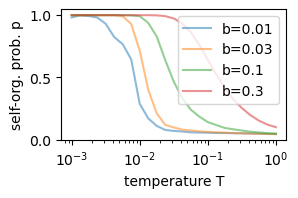

In [31]:
# plt.figure(figsize=(4,2.5))
# b_arr=[0.3,0.1]
plt.figure(figsize=(2.9,1.7))
plt.plot(T_arr, fin_fracK51[::1,:].T,'-',label=b_arr[::-1], alpha=0.5); plt.xscale('log'); #plt.yscale('log')
plt.ylabel('self-org. prob. p'); plt.xlabel('temperature T'); #plt.ylim([0,1]) #plt.xlim([1e-3,1e-1]); 
plt.legend(["b=0.01", "b=0.03", "b=0.1", "b=0.3"][::1]);

[ 0.57296331 -0.99760298]


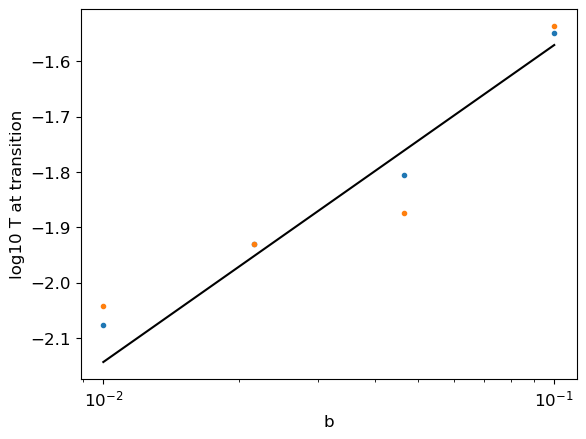

In [3518]:
## Transition T vs b
Tarr_f=np.mean(fin_frac,axis=1) # faction of T_arr before the transition
lT_arr=np.log10(T_arr); lT_trans=np.min(lT_arr) + Tarr_f*(np.max(lT_arr)-np.min(lT_arr))
lT_trans1=np.log10(T_arr[np.argmax(fin_frac<0.5, axis=1)])
plt.semilogx(b_arr, lT_trans,'.'); 
plt.semilogx(b_arr,lT_trans1,'.');
plt.ylabel('log10 T at transition'); plt.xlabel('b');

# msk=msk & np.isfinite(np.log(fit_pars[:,0])); 
lfit=np.polyfit(np.log10(b_arr[:-1]), lT_trans[:-1], deg=1)#, w=rem_frac[msk])
plt.plot(b_arr, lfit[0]*np.log10(b_arr)+lfit[1],'k')
print(lfit)

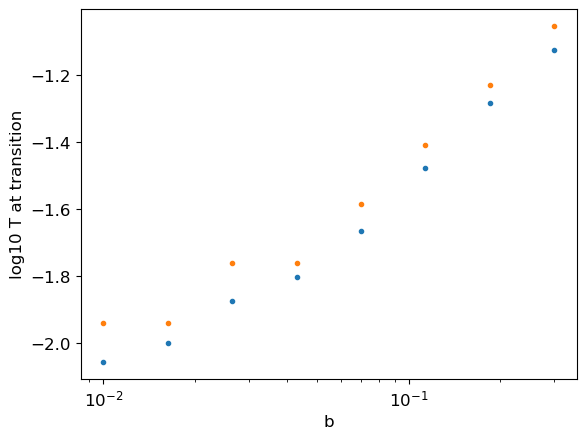

In [1838]:
## Transition T vs b
Tarr_f=np.mean(fin_frac,axis=1) # faction of T_arr before the transition
lT_arr=np.log10(T_arr); lT_trans=np.min(lT_arr) + Tarr_f*(np.max(lT_arr)-np.min(lT_arr))
plt.semilogx(b_arr, lT_trans,'.'); 
plt.semilogx(b_arr,np.log10(T_arr[np.argmax(fin_frac<0.5, axis=1)]),'.');
plt.ylabel('log10 T at transition'); plt.xlabel('b');

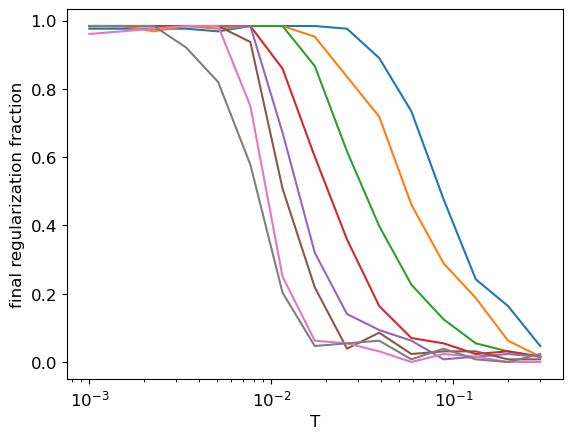

In [1834]:
plt.plot(T_arr, fin_frac.T,'-'); plt.xscale('log'); #plt.yscale('log')
plt.ylabel('final regularization fraction'); plt.xlabel('T'); #plt.xlim([0,None]);

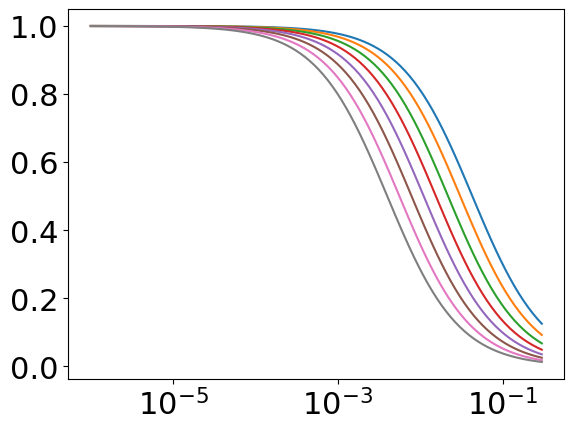

In [1980]:
aT_arr= np.geomspace(1e-6,3e-1,100)[:,None]
ab_arr= np.geomspace(1e-2,3e-1,8)[None,::-1]
plt.semilogx(aT_arr, 1/(5*(2*ab_arr*aT_arr)*(ab_arr**-1.7) + 1));

## -K-b-T full phase boundary: shape and prediction [not used in the paper]

### -- KHN - many-body

In [959]:
def KR_ord(K,b,T):
  th,v,reg_frac,_ = run_KR(max_steps=4*2*1024, nIC=64, #early_stop=False,
                               n_thresh=16, n_wind=10, lyap_thresh=0.,
                               # K=K, freq=0, b=b, T=T,
                               # K=6.4, freq=1/15, b=p, T=0e-5, Lam=Lam2, 
                               # K=4, freq=1/10, b=b, T=T, Lam=Lam,
                               K=K, freq=1/10, b=b, T=T, Lam=2*Lam, #K=0.4, freq=1/10, b=5e-3, T=50e-5, Lam=2*Lam
                               plot=False)
  return np.mean(reg_frac[np.isfinite(reg_frac)][-10:]);
KR_ord(1.,0.03,1e-4)

0.9984375

In [961]:
from scipy.optimize import root_scalar

# K_arr = 6.53-np.geomspace(1e-2,1.5,4)
# b_arr = np.geomspace(3e-2,3e-1,3)
K_arr = [1.]#6.75-np.geomspace(1e-1,4,25)
b_arr = np.geomspace(3e-2,1e0,8)
phase_bdry = np.nan*np.zeros((len(K_arr),len(b_arr),4));
for iK, K in enumerate(K_arr):
  print(iK,K)
  for ib,b in enumerate(tqdm(b_arr)):
    fn_evals=[]
    def tracked_target(lT):
      prob = KR_ord(K,b,10**lT)
      fn_evals.append((lT,prob))
      return 0.5-prob
    try: res=root_scalar(tracked_target, bracket=[-9, 0.7], method='brentq',
                   xtol=3e-2, maxiter=15)
    except ValueError: 
      print(f"at K={K:.4f}, b={b:.4f}, no transition found")
      continue
    # linear interpolation to improve precistion:
    fn_evals=np.array(fn_evals)
    relevant = fn_evals[np.abs(fn_evals[:,1]-0.5)<0.3,:]
    if relevant.shape[0]>1:
      m, c = np.polyfit(relevant[:,0], relevant[:,1], 1)  # Linear fit: y = mx + c
      trans_val = (0.5 - c) / m # Solve for x when y = 0.5
    elif relevant.shape[0]==1: trans_val = relevant[0,0]
    else: trans_val = np.nan
    phase_bdry[iK,ib,:] = [res.root, res.converged, fn_evals[-1][1], trans_val]

0 1.0


 62%|██████▎   | 5/8 [01:18<00:40, 13.56s/it]

at K=1.0000, b=0.2225, no transition found


 75%|███████▌  | 6/8 [01:19<00:18,  9.31s/it]

at K=1.0000, b=0.3672, no transition found


 88%|████████▊ | 7/8 [01:20<00:06,  6.59s/it]

at K=1.0000, b=0.6060, no transition found


100%|██████████| 8/8 [01:21<00:00, 10.20s/it]

at K=1.0000, b=1.0000, no transition found


array([0.80373544, 1.00927986])

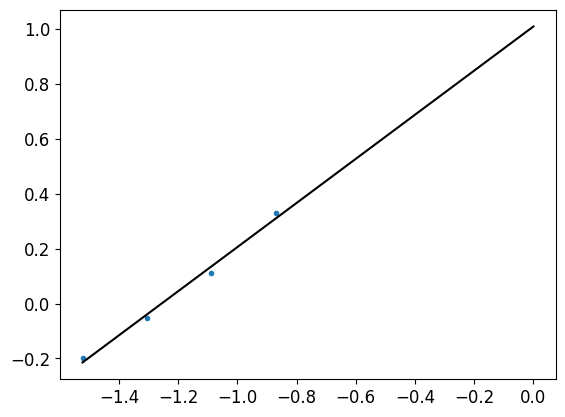

In [977]:
x_dat = np.log10(b_arr); y_dat = phase_bdry[0,:,0];
plt.plot(x_dat, y_dat,'.');

msk = np.isfinite(y_dat)
lfit = np.polyfit(x_dat[msk], y_dat[msk], deg=1);
plt.plot(x_dat, lfit[0]*x_dat + lfit[1],'k')
lfit

### -- Single KR

In [259]:
def KR_ord(K,b,T):
  th,v,reg_frac,_ = run_KR(max_steps=4*16*1024, nIC=64, #early_stop=False,
                               n_thresh=16, n_wind=10, lyap_thresh=0.3,
                               K=K, freq=0, b=b, T=T,
                               # K=6.4, freq=1/15, b=p, T=0e-5, Lam=Lam2, 
                               # K=4, freq=1/10, b=b, T=T, Lam=Lam,
                               plot=False)
  return np.mean(reg_frac[np.isfinite(reg_frac)][-10:]);
KR_ord(5,0.1,1e-1)

0.15625

In [641]:
K_arr = 6.75-np.geomspace(1e-1,4,25)

In [261]:
from scipy.optimize import root_scalar

# K_arr = 6.53-np.geomspace(1e-2,1.5,4)
# b_arr = np.geomspace(3e-2,3e-1,3)
K_arr = 6.75-np.geomspace(1e-1,4,25)
b_arr = np.geomspace(3e-2,2e0,22)
phase_bdry = np.nan*np.zeros((len(K_arr),len(b_arr),4));
for iK, K in enumerate(K_arr):
  print(iK,K)
  for ib,b in enumerate(tqdm(b_arr)):
    fn_evals=[]
    def tracked_target(lT):
      prob = KR_ord(K,b,10**lT)
      fn_evals.append((lT,prob))
      return 0.5-prob
    try: res=root_scalar(tracked_target, bracket=[-9, 0.7], method='brentq',
                   xtol=3e-2, maxiter=15)
    except ValueError: 
      print(f"at K={K:.4f}, b={b:.4f}, no transition found")
      continue
    # linear interpolation to improve precistion:
    fn_evals=np.array(fn_evals)
    relevant = fn_evals[np.abs(fn_evals[:,1]-0.5)<0.3,:]
    if relevant.shape[0]>1:
      m, c = np.polyfit(relevant[:,0], relevant[:,1], 1)  # Linear fit: y = mx + c
      trans_val = (0.5 - c) / m # Solve for x when y = 0.5
    elif relevant.shape[0]==1: trans_val = relevant[0,0]
    else: trans_val = np.nan
    phase_bdry[iK,ib,:] = [res.root, res.converged, fn_evals[-1][1], trans_val]

0 6.65


  5%|▍         | 1/22 [00:17<06:14, 17.85s/it]

at K=6.6500, b=0.0300, no transition found


  9%|▉         | 2/22 [00:27<04:19, 12.97s/it]

at K=6.6500, b=0.0366, no transition found


 14%|█▎        | 3/22 [00:36<03:32, 11.17s/it]

at K=6.6500, b=0.0448, no transition found


 18%|█▊        | 4/22 [00:45<03:05, 10.32s/it]

at K=6.6500, b=0.0547, no transition found


 23%|██▎       | 5/22 [00:54<02:49,  9.99s/it]

at K=6.6500, b=0.0668, no transition found


 27%|██▋       | 6/22 [01:04<02:38,  9.92s/it]

at K=6.6500, b=0.0815, no transition found


 32%|███▏      | 7/22 [01:13<02:25,  9.73s/it]

at K=6.6500, b=0.0996, no transition found


 36%|███▋      | 8/22 [01:23<02:16,  9.76s/it]

at K=6.6500, b=0.1216, no transition found


100%|██████████| 22/22 [08:46<00:00, 23.95s/it]


1 6.6333855147381895


  5%|▍         | 1/22 [00:08<03:01,  8.63s/it]

at K=6.6334, b=0.0300, no transition found


  9%|▉         | 2/22 [00:17<02:49,  8.48s/it]

at K=6.6334, b=0.0366, no transition found


 14%|█▎        | 3/22 [00:25<02:39,  8.41s/it]

at K=6.6334, b=0.0448, no transition found


 18%|█▊        | 4/22 [00:34<02:35,  8.64s/it]

at K=6.6334, b=0.0547, no transition found


 23%|██▎       | 5/22 [00:43<02:27,  8.69s/it]

at K=6.6334, b=0.0668, no transition found


 27%|██▋       | 6/22 [00:51<02:20,  8.75s/it]

at K=6.6334, b=0.0815, no transition found


 32%|███▏      | 7/22 [01:00<02:09,  8.64s/it]

at K=6.6334, b=0.0996, no transition found


 86%|████████▋ | 19/22 [07:23<01:07, 22.54s/it]

at K=6.6334, b=1.0977, no transition found


100%|██████████| 22/22 [08:30<00:00, 23.21s/it]


2 6.614010618271229


  5%|▍         | 1/22 [00:08<03:02,  8.67s/it]

at K=6.6140, b=0.0300, no transition found


  9%|▉         | 2/22 [00:17<02:55,  8.79s/it]

at K=6.6140, b=0.0366, no transition found


 14%|█▎        | 3/22 [00:26<02:44,  8.68s/it]

at K=6.6140, b=0.0448, no transition found


 18%|█▊        | 4/22 [00:34<02:32,  8.49s/it]

at K=6.6140, b=0.0547, no transition found


 23%|██▎       | 5/22 [00:43<02:27,  8.66s/it]

at K=6.6140, b=0.0668, no transition found


 27%|██▋       | 6/22 [00:52<02:23,  8.96s/it]

at K=6.6140, b=0.0815, no transition found


100%|██████████| 22/22 [09:09<00:00, 24.99s/it]


3 6.591416682486276


  5%|▍         | 1/22 [00:09<03:09,  9.04s/it]

at K=6.5914, b=0.0300, no transition found


  9%|▉         | 2/22 [00:17<02:52,  8.62s/it]

at K=6.5914, b=0.0366, no transition found


 14%|█▎        | 3/22 [00:25<02:41,  8.48s/it]

at K=6.5914, b=0.0448, no transition found


 18%|█▊        | 4/22 [00:34<02:33,  8.51s/it]

at K=6.5914, b=0.0547, no transition found


100%|██████████| 22/22 [09:54<00:00, 27.01s/it]


4 6.5650688805702675


  5%|▍         | 1/22 [00:11<04:01, 11.50s/it]

at K=6.5651, b=0.0300, no transition found


  9%|▉         | 2/22 [00:21<03:29, 10.48s/it]

at K=6.5651, b=0.0366, no transition found


 14%|█▎        | 3/22 [00:29<03:00,  9.48s/it]

at K=6.5651, b=0.0448, no transition found


 18%|█▊        | 4/22 [00:38<02:44,  9.14s/it]

at K=6.5651, b=0.0547, no transition found


 23%|██▎       | 5/22 [00:46<02:30,  8.87s/it]

at K=6.5651, b=0.0668, no transition found


100%|██████████| 22/22 [09:47<00:00, 26.68s/it]


5 6.534343526988113


  5%|▍         | 1/22 [00:09<03:21,  9.60s/it]

at K=6.5343, b=0.0300, no transition found


  9%|▉         | 2/22 [00:18<03:08,  9.41s/it]

at K=6.5343, b=0.0366, no transition found


 14%|█▎        | 3/22 [00:27<02:54,  9.19s/it]

at K=6.5343, b=0.0448, no transition found


 18%|█▊        | 4/22 [00:36<02:39,  8.87s/it]

at K=6.5343, b=0.0547, no transition found


 23%|██▎       | 5/22 [00:44<02:27,  8.67s/it]

at K=6.5343, b=0.0668, no transition found


 27%|██▋       | 6/22 [00:52<02:17,  8.57s/it]

at K=6.5343, b=0.0815, no transition found


100%|██████████| 22/22 [08:40<00:00, 23.65s/it]


6 6.498513314063413


  5%|▍         | 1/22 [00:08<03:03,  8.73s/it]

at K=6.4985, b=0.0300, no transition found


100%|██████████| 22/22 [11:37<00:00, 31.69s/it]


7 6.456730095693063


  5%|▍         | 1/22 [00:09<03:09,  9.04s/it]

at K=6.4567, b=0.0300, no transition found


  9%|▉         | 2/22 [00:17<02:53,  8.70s/it]

at K=6.4567, b=0.0366, no transition found


100%|██████████| 22/22 [10:40<00:00, 29.13s/it]


at K=6.4567, b=2.0000, no transition found
8 6.408004810664661


100%|██████████| 22/22 [11:40<00:00, 31.83s/it]


at K=6.4080, b=2.0000, no transition found
9 6.35118407033644


100%|██████████| 22/22 [12:26<00:00, 33.92s/it]


10 6.284922856480734


100%|██████████| 22/22 [11:13<00:00, 30.61s/it]


at K=6.2849, b=2.0000, no transition found
11 6.207652683014676


100%|██████████| 22/22 [10:07<00:00, 27.61s/it]


at K=6.2077, b=2.0000, no transition found
12 6.117544467966324


100%|██████████| 22/22 [10:42<00:00, 29.20s/it]


at K=6.1175, b=2.0000, no transition found
13 6.012465236809083


100%|██████████| 22/22 [11:25<00:00, 31.15s/it]


at K=6.0125, b=2.0000, no transition found
14 5.889927632277999


100%|██████████| 22/22 [11:32<00:00, 31.48s/it]


at K=5.8899, b=2.0000, no transition found
15 5.747031035501921


100%|██████████| 22/22 [11:36<00:00, 31.65s/it]


16 5.580392904714854


 95%|█████████▌| 21/22 [09:56<00:18, 18.71s/it]

at K=5.5804, b=1.6375, no transition found


100%|██████████| 22/22 [09:56<00:00, 27.12s/it]


17 5.386068706247612


100%|██████████| 22/22 [09:32<00:00, 26.03s/it]


18 5.159458542465899


100%|██████████| 22/22 [09:14<00:00, 25.21s/it]


19 4.895198266420907


100%|██████████| 22/22 [09:02<00:00, 24.65s/it]


20 4.587032505759602


100%|██████████| 22/22 [09:18<00:00, 25.37s/it]


21 4.227666590211276


 91%|█████████ | 20/22 [07:59<00:25, 12.92s/it]

at K=4.2277, b=1.3407, no transition found


 95%|█████████▌| 21/22 [08:03<00:10, 10.35s/it]

at K=4.2277, b=1.6375, no transition found


100%|██████████| 22/22 [08:04<00:00, 22.00s/it]


22 3.808593877588205


 95%|█████████▌| 21/22 [08:27<00:07,  7.58s/it]

at K=3.8086, b=1.6375, no transition found


100%|██████████| 22/22 [08:27<00:00, 23.08s/it]


23 3.319894390890103


 82%|████████▏ | 18/22 [06:56<00:45, 11.31s/it]

at K=3.3199, b=0.8987, no transition found


 86%|████████▋ | 19/22 [07:00<00:27,  9.19s/it]

at K=3.3199, b=1.0977, no transition found


 95%|█████████▌| 21/22 [07:01<00:04,  4.70s/it]

at K=3.3199, b=1.6375, no transition found


100%|██████████| 22/22 [07:01<00:00, 19.16s/it]


24 2.75


 68%|██████▊   | 15/22 [06:12<02:09, 18.45s/it]

at K=2.7500, b=0.4932, no transition found


 86%|████████▋ | 19/22 [06:13<00:14,  4.76s/it]

at K=2.7500, b=1.0977, no transition found


 91%|█████████ | 20/22 [06:14<00:07,  3.55s/it]

at K=2.7500, b=1.3407, no transition found


100%|██████████| 22/22 [06:14<00:00, 17.04s/it]


In [247]:
phase_bdry

array([[[        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [-4.11699141,  1.        ,  0.5       , -4.11371482],
        [-2.84360147,  1.        ,  0.525     , -2.84086129],
        [-2.21740492,  1.        ,  0.4578125 , -2.21042135]],

      

In [236]:
phase_bdry_bck=phase_bdry.copy()

In [257]:
phase_bdry_bckLong=phase_bdry.copy()

In [337]:
phase_bdry=phase_bdry_bckHRes.copy()

In [527]:
isl_frac = isl_frac_bckHres.copy()

In [94]:
np.savetxt("KR_KBT_phase_bdry_25x22x7_eta.csv", 
           np.concatenate((np.tile(K_arr,[phase_bdry.shape[1],1]).T[:,:,None],
                np.tile(isl_frac,[phase_bdry.shape[1],1]).T[:,:,None], 
                np.tile(-dat[:,1],[phase_bdry.shape[1],1]).T[:,:,None], #eta
                np.tile(b_arr,[phase_bdry.shape[0],1])[:,:,None],
                phase_bdry), axis=2).flatten(), delimiter=",")
# 3rd dim: K values, eps (island fractions), etas (tau-b scaling, measured), b values, T_c, converged flag, 
# final prob at T_c (should be ~0.5), T_c interp estimate

In [112]:
K_arr = 6.75-np.geomspace(1e-1,4,25)
b_arr = np.geomspace(3e-2,2e0,22)
ldData=np.reshape(np.genfromtxt("KR_KBT_phase_bdry_25x22x7_eta.csv", delimiter=",", skip_header=0), [25,22,8])
phase_bdry = ldData[:,:,4:]
isl_frac = ldData[:,0,1]
etas = ldData[:,0,2]

Text(0, 0.5, '$log_{10}(T^*)$')

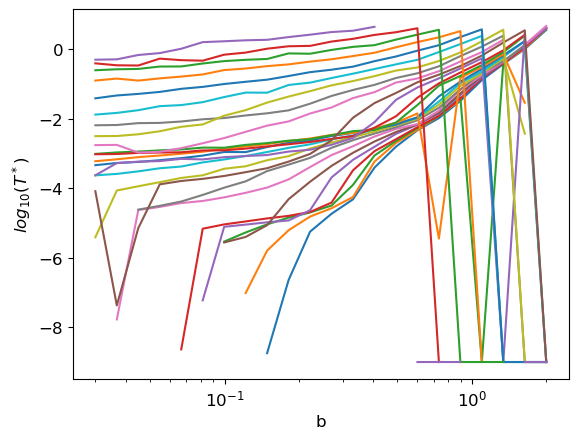

In [275]:
plt.plot(b_arr, phase_bdry[:,:,0].T)
plt.xscale('log'); plt.xlabel('b'); plt.ylabel(r'$log_{10}(T^*)$')

In [114]:
phase_bdry[:,:,0][phase_bdry[:,:,0]<-6]=np.nan

In [116]:
phase_bdry[:,:,0][np.abs(phase_bdry[:,:,2]-0.5)>0.1]=np.nan

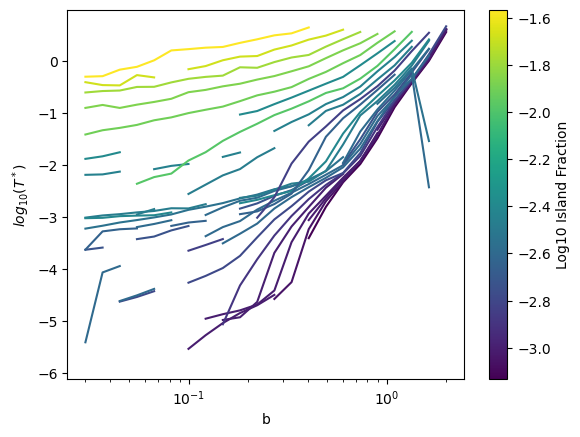

In [118]:
### Plot curves by color ####
def plot_colored(x,Y,col, style='-', clabel=''):
    # Normalize isl_frac for colormap
    norm = plt.Normalize(col.min(), col.max())
    colors = plt.cm.viridis(norm(col))  # Map isl_frac to colors

    # Plot each line with corresponding color
    fig, ax = plt.subplots()
    for i in range(Y.shape[1]):
        ax.plot(x, Y[:,i], style, color=colors[i])

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Required for ScalarMappable
    cbar = fig.colorbar(sm, ax=ax, label=clabel)
    
plot_colored(b_arr, phase_bdry[:, :, 0].T, np.log10(isl_frac), clabel='Log10 Island Fraction')
plt.xscale('log'); plt.xlabel('b'); plt.ylabel(r'$log_{10}(T^*)$');

In [120]:
# linear fits to each line
coeffs = []
for Ki in range(K_arr.shape[0]):
  msk = ~np.isnan(phase_bdry[Ki,:,0])
  coeffs.append(np.polyfit(np.log10(b_arr[msk]), phase_bdry[Ki,msk,0].T, deg=1))

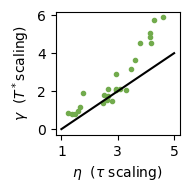

In [122]:
# estimate eta from fit
eps=isl_frac
eta = eps**(-0.36389394) * np.exp(-1.09513883)
plt.figure(figsize=(1.6,1.6))
plt.plot(eta, np.array(coeffs)[:,0],'.', color=np.array([114,172,77])/256);
plt.plot([1,5],[0,4],'k');
plt.xlabel(r"$\eta$  ($\tau$ scaling)"); plt.ylabel(r"$\gamma$  ($T^*$scaling)");
plt.xticks([1,3,5]);
# plt.xscale('log')

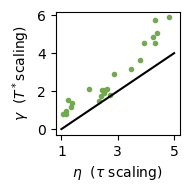

In [126]:
# measure eta
eps=isl_frac
eta = eps**(-0.36389394) * np.exp(-1.09513883)
plt.figure(figsize=(1.6,1.6))
plt.plot(etas, np.array(coeffs)[:,0],'.', color=np.array([114,172,77])/256);
plt.plot([1,5],[0,4],'k');
plt.xlabel(r"$\eta$  ($\tau$ scaling)"); plt.ylabel(r"$\gamma$  ($T^*$scaling)");
plt.xticks([1,3,5]);
# plt.xscale('log')

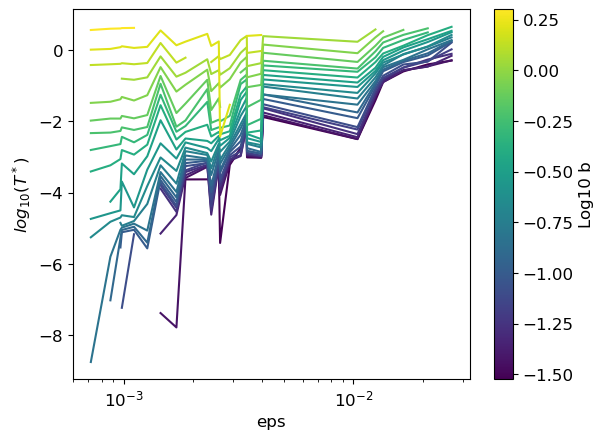

In [383]:
order = np.argsort(isl_frac)
plot_colored(isl_frac[order], phase_bdry[order, :, 0], np.log10(b_arr), '-', clabel='Log10 b')
plt.xscale('log'); plt.xlabel('eps'); plt.ylabel(r'$log_{10}(T^*)$');

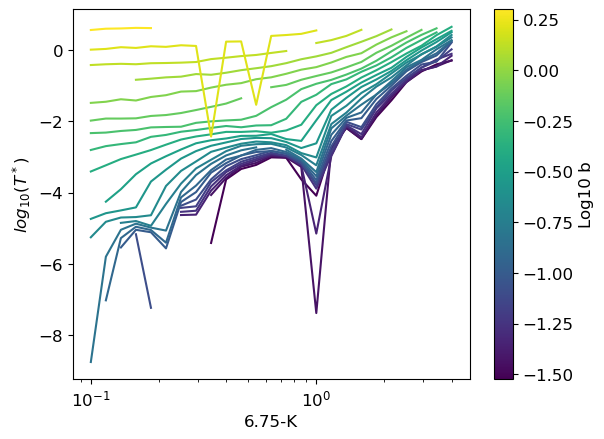

In [389]:
plot_colored(6.75-K_arr, phase_bdry[:, :, 0], np.log10(b_arr), '-', clabel='Log10 b')
plt.xscale('log'); plt.xlabel('6.75-K'); plt.ylabel(r'$log_{10}(T^*)$');

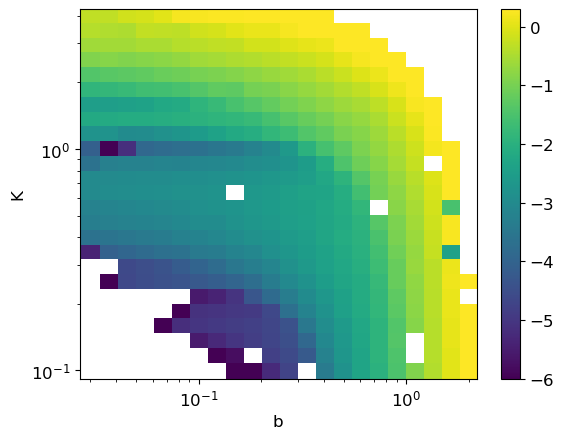

In [323]:
plt.pcolormesh(b_arr, 6.75-K_arr, phase_bdry[:,:,0]);
plt.xscale('log'); plt.yscale('log'); plt.ylabel('K'); plt.xlabel('b')
plt.colorbar(); plt.clim([-6,0.3])

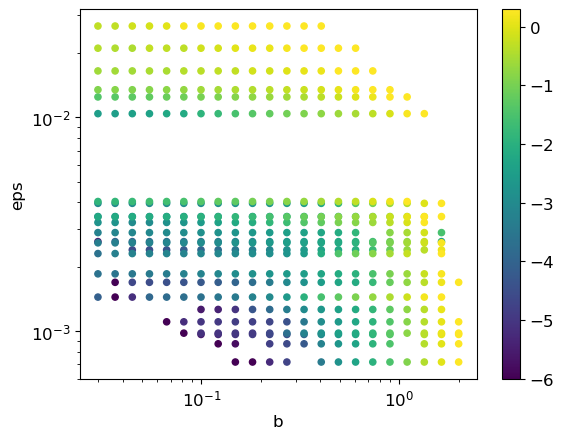

In [385]:
b_Arr, eps_Arr = np.meshgrid(b_arr, isl_frac)#6.75-K_arr)
plt.scatter(b_Arr.flatten(), eps_Arr.flatten(), c=phase_bdry[:,:,0].flatten(), s=20)
plt.xscale('log'); plt.yscale('log'); plt.ylabel('eps'); plt.xlabel('b'); 
plt.colorbar(); plt.clim([-6,0.3])

In [ ]:
plt.scatter(b_arr, 6.75-K_arr, phase_bdry[:,:,0]);
plt.xscale('log'); #plt.yscale('log'); 
plt.colorbar();

In [127]:
from scipy.optimize import root_scalar
t0 = time.time()
fn_evals=[]
def tracked_target(lT):
  prob = KR_ord(5,0.1,10**lT)
  fn_evals.append((lT,prob))
  return 0.5-prob
res=root_scalar(tracked_target, bracket=[-5, -1], method='brentq',
               xtol=3e-2, maxiter=10)
print(time.time()-t0)

38.34839487075806


In [64]:
res

      converged: False
           flag: convergence error
 function_calls: 4
     iterations: 2
           root: -1.567896625391492

In [145]:
fn_evals=np.array(fn_evals)
relevant = fn_evals[np.abs(fn_evals[:,1]-0.5)<0.1,:]
print(relevant.shape)
m, c = np.polyfit(relevant[:,0], relevant[:,1], 1)  # Linear fit: y = mx + c
trans_val = (0.5 - c) / m 
trans_val

(3, 2)


-1.5453930284171513

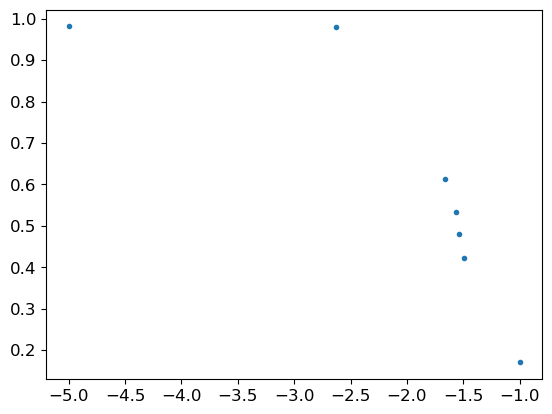

In [139]:
plt.plot(fn_evals[:,0], fn_evals[:,1],'.')

### -- Compare to prediction

The hypergeometric here comes from computing the first passage time for a particle diffusing inside an island of order, with a spring-like restoring force = -b v

In [919]:
import numpy as np
from scipy.optimize import minimize
from mpmath import hyper


def objective_function(T, b, eps): # Define the objective function
  a2=eps*(2*np.pi)**2 * (1+b)**2
  al= float(a2/(2*T))
  eta = eps**(-0.36389394) * np.exp(-1.09513883) # fits from relaxation data - slope
  mult = 10**(0.8-(np.log10(eps)+2.3)**2) # intersept
  # mult = np.exp(-9)*(1.35**-eta)#(10*eps)**0.2
  return (mult*(b)**(1-eta) -  al*float(hyper([1, 1], [1.5, 2], al)))**2 # squared difference between LHS and RHS of the equation
def get_crit_T(b, eps, initial_guess): # Solver function using local optimization
  return minimize(objective_function, initial_guess, args=(b, eps), method='Powell')


solution = get_crit_T(1., 0.01, 0.1)
print(f"Solution for alpha: {solution.x[0] }")
print(f"Objective function value: {solution.fun }")

Solution for alpha: 0.36994238639525984
Objective function value: 0.0


/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_80260/1602277741.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  al= float(a2/(2*T))


In [921]:
Ksel = range(len(K_arr))#[5,9,20,24]
b_arrP=np.geomspace(0.01,3,25)
eps_arr = isl_frac[Ksel]
Tc_pred = []
for eps in tqdm(eps_arr):
  Tc_pred.append([get_crit_T(b=b, eps=eps, initial_guess=0.1).x[0] for b in b_arrP])

  0%|          | 0/25 [00:00<?, ?it/s]/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_80260/1602277741.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  al= float(a2/(2*T))
  8%|▊         | 2/25 [00:02<00:25,  1.09s/it]/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_80260/1602277741.py:12: RuntimeWarning: overflow encountered in scalar power
  return (mult*(b)**(1-eta) -  al*float(hyper([1, 1], [1.5, 2], al)))**2 # squared difference between LHS and RHS of the equation
100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


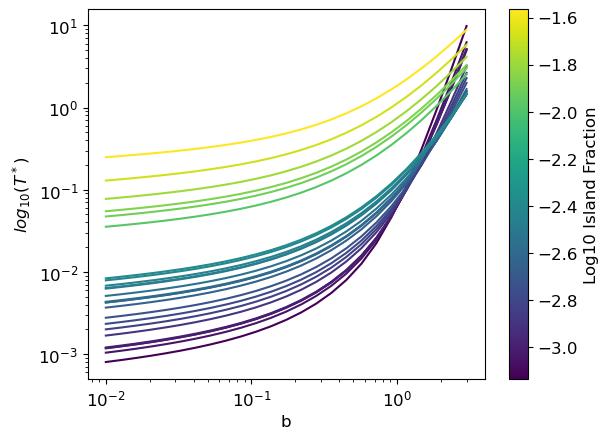

In [922]:
#### Compare to predictions
plot_colored(b_arrP, 1*np.array(Tc_pred).T, np.log10(isl_frac), clabel='Log10 Island Fraction')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('b'); plt.ylabel(r'$log_{10}(T^*)$');
# plt.axis([0.02,2,10**-5, 2]);

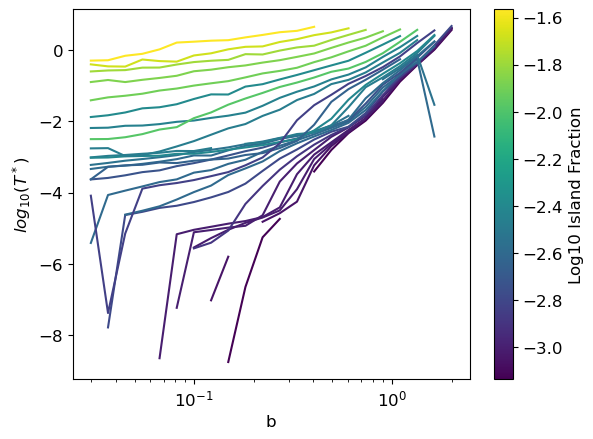

In [829]:
plot_colored(b_arr, phase_bdry[:, :, 0].T, np.log10(isl_frac), clabel='Log10 Island Fraction')
plt.xscale('log'); plt.xlabel('b'); plt.ylabel(r'$log_{10}(T^*)$');

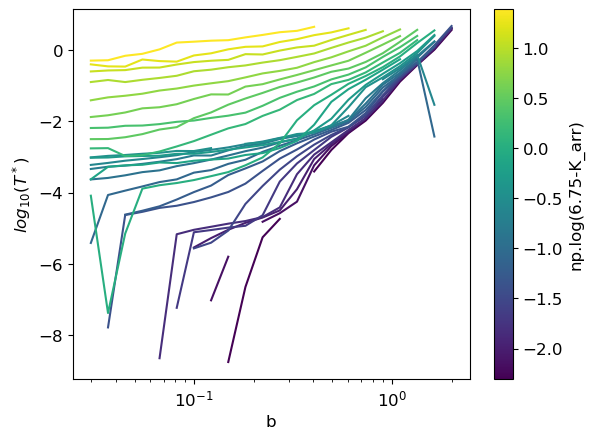

In [833]:
plot_colored(b_arr, phase_bdry[:, :, 0].T, np.log(6.75-K_arr), clabel='np.log(6.75-K_arr)')
plt.xscale('log'); plt.xlabel('b'); plt.ylabel(r'$log_{10}(T^*)$');

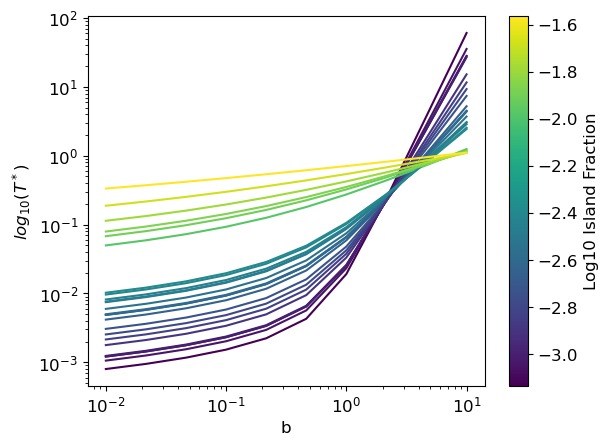

In [839]:
#### Compare to predictions
plot_colored(b_arrP, 1*np.array(Tc_pred).T, np.log10(isl_frac), clabel='Log10 Island Fraction')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('b'); plt.ylabel(r'$log_{10}(T^*)$');

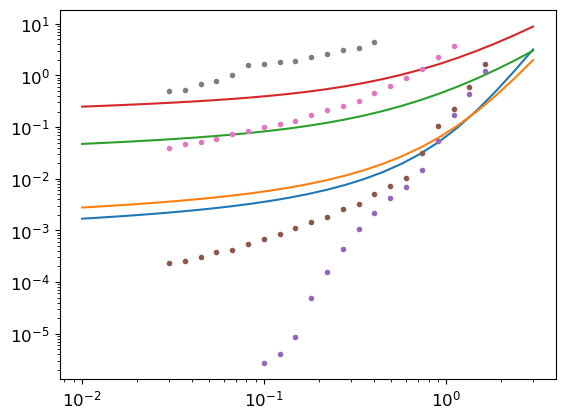

In [927]:
Ksel=[5,9,20,24]
plt.loglog(b_arrP, 1*np.array(Tc_pred)[Ksel,:].T);
plt.loglog(b_arr, 10**phase_bdry[Ksel, :, 0].T,'.');

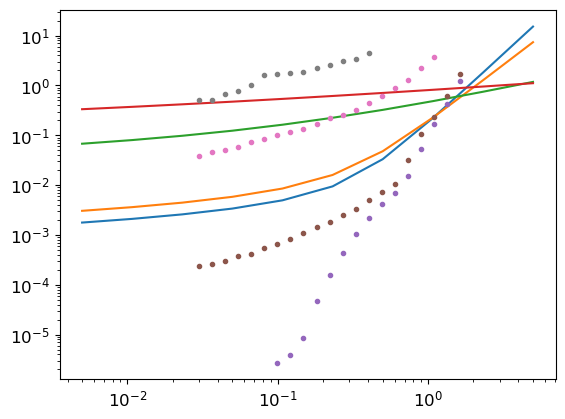

In [635]:
plt.loglog(0.5*b_arrP, 1*np.array(Tc_pred).T);
plt.loglog(b_arr, 10**phase_bdry[Ksel, :, 0].T,'.');

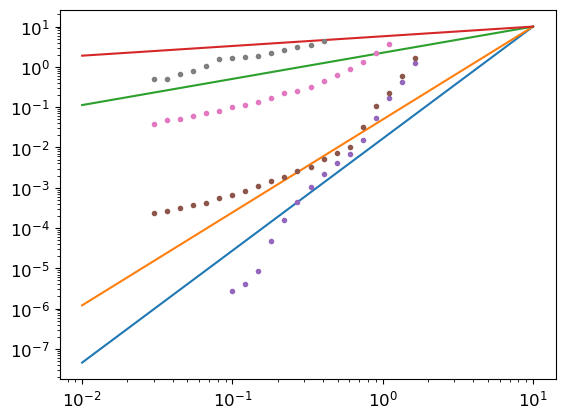

In [784]:
Ksel = [5,9,20,24]
eps_arr = isl_frac[Ksel]
eta_arr = eps_arr**(-0.36389394) * np.exp(-1.09513883)
plt.loglog(b_arrP, 10*(0.1*b_arrP[:,None])**(eta_arr[None,:]-1));
plt.loglog(b_arr, 10**phase_bdry[Ksel, :, 0].T,'.');

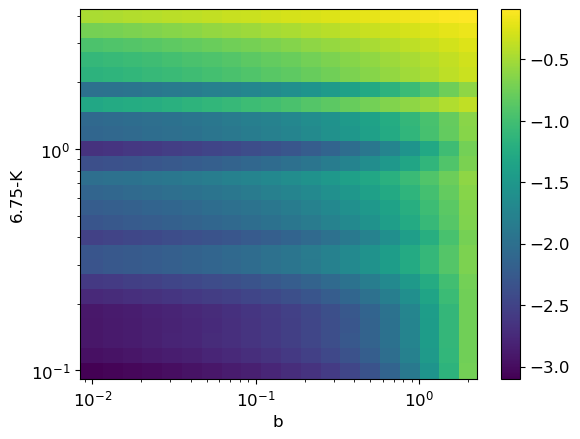

In [851]:
plt.pcolormesh(b_arrP, 6.75-K_arr, np.log10(Tc_pred));
plt.xscale('log'); plt.yscale('log'); plt.ylabel('6.75-K'); plt.xlabel('b')
plt.colorbar(); #plt.clim([-3,0.5])

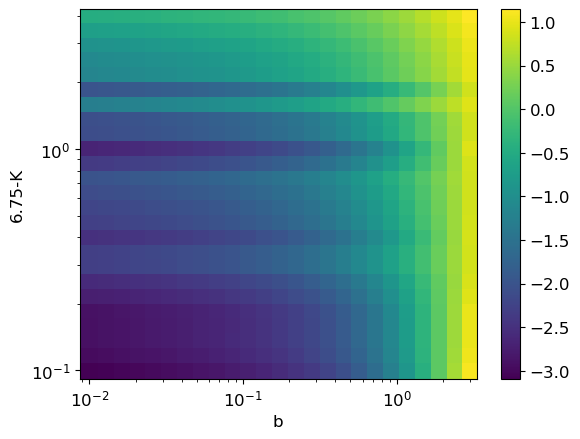

In [881]:
plt.pcolormesh(b_arrP, 6.75-K_arr, np.log10(Tc_pred));
plt.xscale('log'); plt.yscale('log'); plt.ylabel('6.75-K'); plt.xlabel('b')
plt.colorbar(); #plt.clim([-3,0.5])

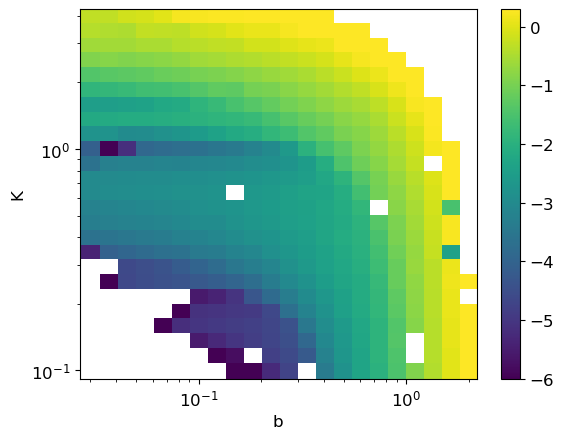

In [323]:
plt.pcolormesh(b_arr, 6.75-K_arr, phase_bdry[:,:,0]);
plt.xscale('log'); plt.yscale('log'); plt.ylabel('K'); plt.xlabel('b')
plt.colorbar(); plt.clim([-6,0.3])

In [523]:
b_arrP=np.geomspace(0.001,1,10)
eps_arr = np.geomspace(0.001,0.1,3)
Tc_arr = []
for eps in tqdm(eps_arr):
  a2=eps*(2*np.pi)**2
  eta = eps**(-0.36389394) * np.exp(-1.09513883)
  Tc_arr.append([get_crit_T(a2=a2, b=b, eta=eta, initial_guess=0.1).x[0] for b in b_arrP])


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_80260/373125054.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  al= float(a2/(2*T))
/var/folders/00/xws3c2c52tv7m8gq2pkjtcl00000gn/T/ipykernel_80260/373125054.py:8: RuntimeWarning: overflow encountered in scalar power
  return (b**(1-eta) -  al*float(hyper([1, 1], [1.5, 2], al)))**2 # squared difference between LHS and RHS of the equation
100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


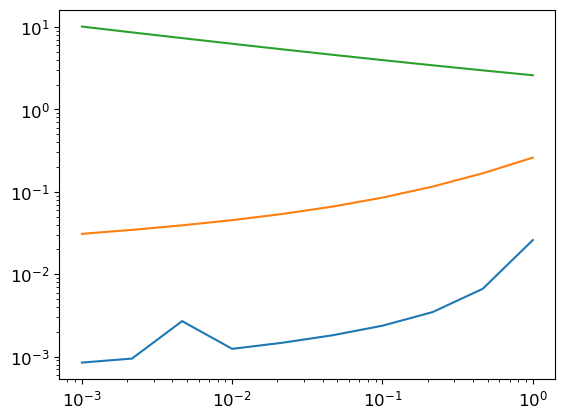

In [525]:
plt.loglog(b_arrP, np.array(Tc_arr).T);
plt.plot(b_arr, phase_bdry[:, :, 0].T)

# Bouncing Ball

$\ddot{x} = -g - b\,\dot{x} + \sqrt{2\,b\,T}\; \xi$

$ x(t) = x_0 + v_0\,t - g\,t^2/2 - v_0\,b\,t^2/2$

In [763]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
# Function to find the next collision time
# y_ball = lambda y0,v0,t: y0 + v0 * t - 0.5 * (g) * t ** 2 # undamped
y_ball = lambda y0,v0,t: y0 + (v0 + g/b)*(1 - np.exp(-b*t))/b - g*t/b #damped
v_ball = lambda v0,t: (v0 + g/b)*np.exp(-b*t) - g/b #damped
def next_collision_time(t, y0, v0):
    # Equations to solve
    def equations(p):
        tc, = p
        y_plate = A * np.sin(omega * tc)
        
        return (y_plate - y_ball(y0,v0,tc - t),)
    
    # Initial guess for the next collision time
    t_guess = t + 2*abs(v0) / g #2 * np.pi / omega #
    tc = fsolve(equations, t_guess)[0]
    return tc

import numpy as np
import matplotlib.pyplot as plt

def full_trajectories(t_collisions, positions, speeds, t_arr, A, omega, g=9.81):
    """
    Plots the trajectories of the bouncing ball and the sinusoidally oscillating plate.

    Parameters:
    - t_collisions: Array of collision times.
    - positions: Array of ball positions at collision times.
    - speeds: Array of ball speeds immediately after collisions.
    - t_arr: Array of times at which to plot the trajectories.
    - A: Amplitude of the plate's sinusoidal motion.
    - omega: Frequency of the plate's sinusoidal motion.
    - g: Gravitational acceleration (default: 9.81 m/s^2).
    """
    # Initialize arrays to store the ball's position and the plate's position
    ball_positions = np.zeros_like(t_arr)
    plate_positions = A * np.sin(omega * t_arr)

    # Calculate the ball's position at each time in t_arr
    for i in range(1, len(t_collisions)):
        # Indices of t_arr that fall between two collisions
        indices = np.where((t_arr >= t_collisions[i-1]) & (t_arr < t_collisions[i]))[0]
        
        # Time since the last collision for these indices
        t_since_collision = t_arr[indices] - t_collisions[i-1]
        
        # Calculate position using the equation of motion
        ball_positions[indices] = positions[i-1] + speeds[i-1] * t_since_collision - 0.5 * g * t_since_collision**2

    # For times after the last collision, extrapolate the last segment of the trajectory
    if t_arr[-1] > t_collisions[-1]:
        indices = np.where(t_arr >= t_collisions[-1])[0]
        t_since_collision = t_arr[indices] - t_collisions[-1]
        ball_positions[indices] = positions[-1] + speeds[-1] * t_since_collision - 0.5 * g * t_since_collision**2

    return ball_positions,plate_positions

100%|██████████| 64/64 [00:01<00:00, 43.54it/s]


249.2394094266043


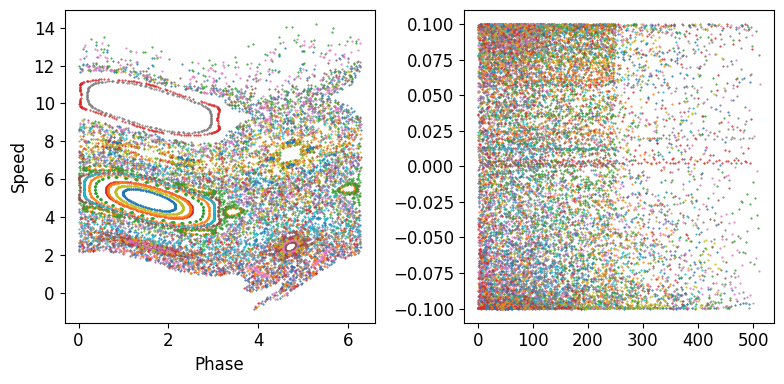

In [803]:
g = 9.81  # Gravity (m/s^2)
e = 1-0.0  # Coefficient of restitution
A = 0.1 # Amplitude of plate oscillation (m)
omega = 2 * np.pi # Frequency of plate oscillation (rad/s)
b=3e-12; T=1e-2;

def bouncing_ball(nIC=64, nSteps=250, #number of random IC to pick; evolution steps
  IC=None): # optionally specify IC as (init plate phase, init v)
  # Simulation
  if IC is not None:
    nIC = IC.shape[0];
  times = np.zeros((nSteps,nIC))
  heights = np.zeros((nSteps,nIC))
  speeds = np.zeros((nSteps,nIC))
  noise_all = np.random.randn(nSteps, nIC) # Einstein relation noise amplitude
  # Initial conditions
  if IC is not None:
    speeds[0,:]=IC[:,1];
    times[0,:]=IC[:,0]/omega;
  else:
    np.random.seed(0)
    # speeds[0,:]=10*(np.random.rand(nIC)-0.5) # Initial velocity (m/s)
    # heights[0,:]=A+4*np.random.rand(nIC) # Initial height (m)
    # times[0,:]=0 # Initial time (s)
    speeds[0,:]=10*(np.random.rand(nIC)) # Initial velocity (m/s)
    times[0,:]=2*np.pi/omega*np.random.rand(nIC)
  heights[0,:]=A * np.sin(omega * times[0,:])

  for ir in tqdm(range(nIC)):
      v_after=speeds[0,ir]
      for it in range(nSteps-1):
          tc = next_collision_time(times[it,ir], heights[it,ir], v_after)
          # if tc > t_max: break
          # vc = v_after - g * (tc - times[it,ir])  # Velocity at collision
          vc = v_ball(v_after, tc - times[it,ir]) + np.sqrt(tc - times[it,ir])*np.sqrt(2*b*T)*noise_all[it,ir] # damped
          vp = A * omega * np.cos(omega * tc)  # Plate velocity at collision
          v_after = -e * (vc - vp) + vp + np.sqrt(2*(1-e)*T)*noise_all[it,ir] # Velocity after collision using conservation of energy
          times[it+1,ir]=tc
          heights[it+1,ir] = A * np.sin(omega * tc)
          speeds[it+1,ir]=v_after
  return times, speeds, heights

times, speeds, heights = bouncing_ball(nSteps=250);

# Plotting
plt.figure(figsize=(8,4))
plt.subplot(121)
tSt=30; plt.plot((omega*times[tSt:]+0*np.pi) % (2*np.pi)-0*np.pi, speeds[tSt:], '.',ms=1)
plt.xlabel('Phase')
plt.ylabel('Speed')
plt.subplot(122)
ir=0
print(np.max(times[:,ir]))
# plot_trajectories(times[:,ir], heights[:,ir], speeds[:,ir], 
#                   np.linspace(0, np.max(times[:,ir]), 400), A, omega)
# plt.ylim([-A,None]);
plt.plot(times[1:], heights[1:], '.',ms=1)
# plt.xlabel('Time (s)')
# plt.ylabel('Height (m)')
# plt.title('Bouncing Ball on a Sinusoidally Oscillating Plate')
plt.tight_layout(); plt.show()

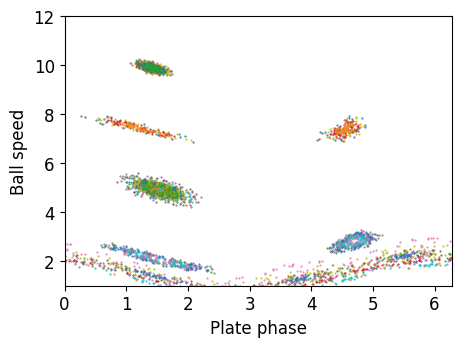

In [797]:
plt.figure(figsize=(5,3.5))
tSt=150; plt.plot((omega*times[tSt:]+0*np.pi) % (2*np.pi)-0*np.pi, speeds[tSt:], '.',ms=1)
plt.xlim([0,2*np.pi]); plt.ylim([1,12]);
plt.xlabel('Plate phase'); plt.ylabel('Ball speed');

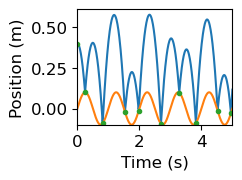

In [1710]:
t_rg=[0,5]#650,658];
t_arr = np.linspace(t_rg[0], t_rg[1], 500)  # Times at which to plot the trajectories
ir=0
ball_positions,plate_positions = full_trajectories(times[:,ir], heights[:,ir], speeds[:,ir], t_arr, A, omega)
plt.figure(figsize=(2,1.5))
plt.plot(t_arr, ball_positions, label='Ball Trajectory')
plt.plot(t_arr, plate_positions, label='Plate Trajectory', linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
# plt.title('Ball and Plate Trajectories')
# plt.legend()
# plt.grid(True)
# plt.show()
plt.plot(times[:,ir], heights[:,ir], '.');
plt.ylim([-A,None]); plt.xlim(t_rg);

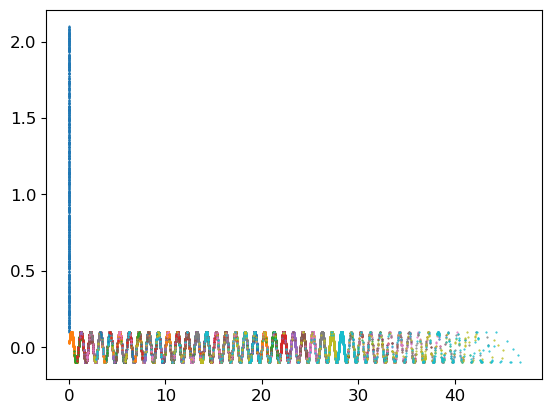

In [1622]:
plt.plot(times, heights, '.',ms=1);

100%|██████████| 16560/16560 [00:32<00:00, 514.46it/s]


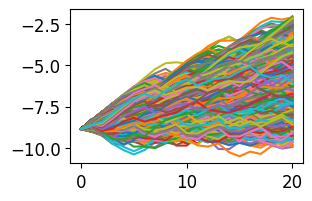

In [581]:
g = 9.81  # Gravity (m/s^2)
e = 1-0.0  # Coefficient of restitution
A = 0.1 # Amplitude of plate oscillation (m)
omega = 2 * np.pi # Frequency of plate oscillation (rad/s)

rng = [0,2*np.pi,0,12]
X,Y = np.meshgrid(np.linspace(rng[0], rng[1], 90), np.linspace(rng[2], rng[3], 92));
IC = np.c_[X.flatten(), Y.flatten()]

def evol_bb(IC, nSteps): 
  times, speeds, heights = bouncing_ball(IC=IC, nSteps=nSteps+1)
  return np.stack([(omega*times) % (2*np.pi), speeds],axis=2)

lyaps = np.reshape(get_lyap(evol_bb, IC, n_wind=20, eps=1e-9), X.shape)

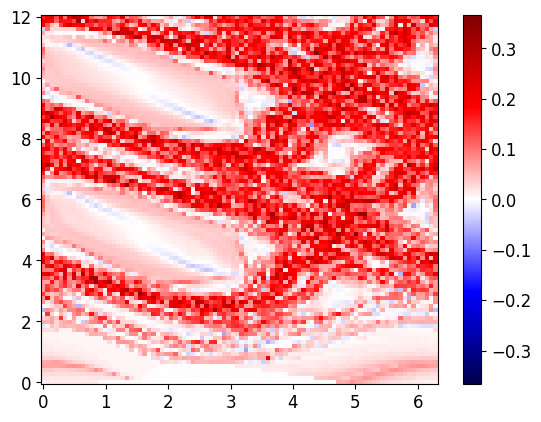

In [582]:
plt.pcolormesh(X,Y, lyaps,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps),np.max(lyaps)])

# Duffing Oscillator

## Duffing Oscillator with Thermal Noise

We simulate many Duffing oscillators in parallel, each driven, damped, and coupled to a thermal bath.

### Equation

$$
\ddot{x} + b \dot{x} + \alpha \, x^3 - \beta \, x = F \sin(\omega t) + \eta(t)
$$

with Gaussian white noise
$$
\langle \eta(t) \eta(t') \rangle = 2 b T \, \delta(t-t')
$$

So wells are at: 
$$
\alpha \, x^3 - \beta \, x = 0 \\
x = \sqrt{\beta/\alpha}
$$

### Method

Integrated by Euler–Maruyama with timestep $\Delta t$, sampling stroboscopically at a fixed drive phase to form the Poincaré map.


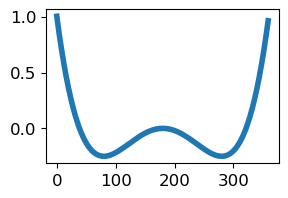

In [881]:
xdom = np.arange(-1.8,1.8,0.01)
plt.figure(figsize=(3,2))
plt.plot(xdom**4 / 4 -xdom**2 /2, linewidth=4)

In [718]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

# Duffing parameters
b, F, omega, T = 0.01, 0.3, 1.2, 0.01   # damping, forcing, drive freq, bath temp
dt, nSteps, nIC = 10e-3, 150000, 256   # timestep, total steps, initial conditions

# ICs
np.random.seed(0)
x0 = 3*(2*np.random.rand(nIC)-1)
v0 = 2*(2*np.random.rand(nIC)-1)
# x0 = np.array([0.]); v0 = np.array([4.]); nIC = len(x0);

# @njit(parallel=True)
def duffing_sim(x, v, dt, nSteps, b, F, omega, T):
    phase_points, xv_points = [], []        
    noise_all = np.sqrt(2*b*T*dt)*np.random.randn(len(x),nSteps) # Einstein relation noise amplitude
    # halfIC=int(len(x)/2); noise_all[halfIC:,:] = noise_all[:halfIC,:];
    t = 0.0
    for step in tqdm(range(nSteps)):
        if (t%(2*np.pi/omega)) < dt:  # strobe near phase 0
            phase_points.append(step)
            xv_points.append(np.column_stack((x.copy(), v.copy())))
        drive = F*np.sin(omega*t)
        noise = noise_all[:,step]
        a = -b*v - x**3 + x + drive + noise
        v += a*dt
        x += v*dt
        t += dt
    return phase_points, xv_points

# Run
phase_points, xv = duffing_sim(x0, v0, dt, nSteps, b, F, omega, T)
all_points = np.array(xv) # (t, IC, xv)
all_points.shape

100%|██████████| 150000/150000 [00:06<00:00, 24731.35it/s]


(287, 256, 2)

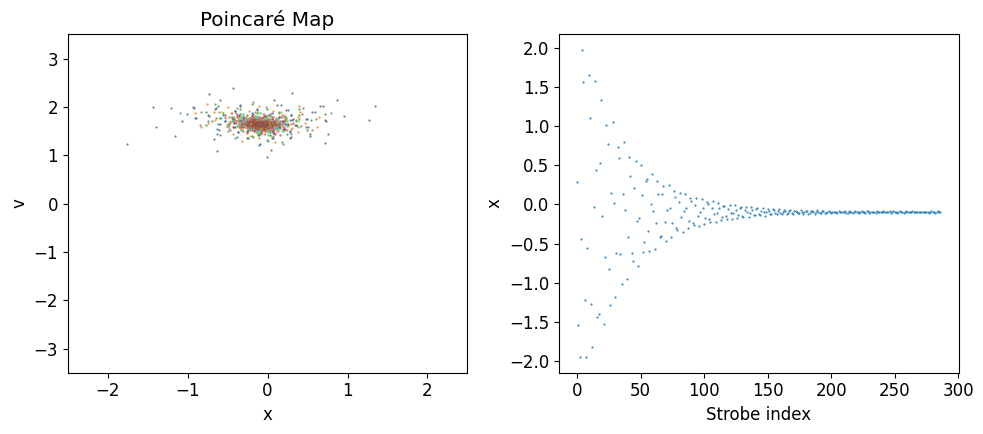

In [720]:
# Visualization
plt.figure(figsize=(10,4.5))
all_points = np.array(xv) # (t, IC, xv)
plt.subplot(121)
tStart = 150
plt.plot(all_points[tStart:,:,0], all_points[tStart:,:,1], '.', ms=1)
plt.axis([-2.5,2.5,-3.5,3.5])
plt.xlabel('x'); plt.ylabel('v'); plt.title('Poincaré Map')

plt.subplot(122)
# Example trajectory
idx = 0
x_traj = all_points[:,idx,0]
plt.plot(np.arange(len(x_traj)), x_traj, '.', ms=1)
plt.xlabel('Strobe index'); plt.ylabel('x')
plt.tight_layout(); plt.show()

100%|██████████| 5239/5239 [00:06<00:00, 789.94it/s] 


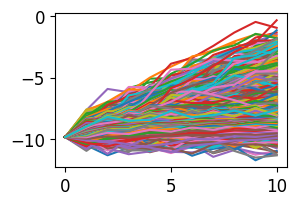

In [644]:
rng = [-2.5,2.5,-3.5,3.5]
X,Y = np.meshgrid(np.linspace(rng[0], rng[1], 90), np.linspace(rng[2], rng[3], 92));
IC = np.c_[X.flatten(), Y.flatten()]

evol = lambda IC, nPer: np.array(duffing_sim(IC[:,0], IC[:,1], dt, 
                                nSteps=int(np.ceil(nPer*2*np.pi/omega/dt))+3, b=0.0, F=F, omega=omega, T=0)[1])
lyaps = np.reshape(get_lyap(evol, IC, n_wind=10, eps=1e-10), X.shape)

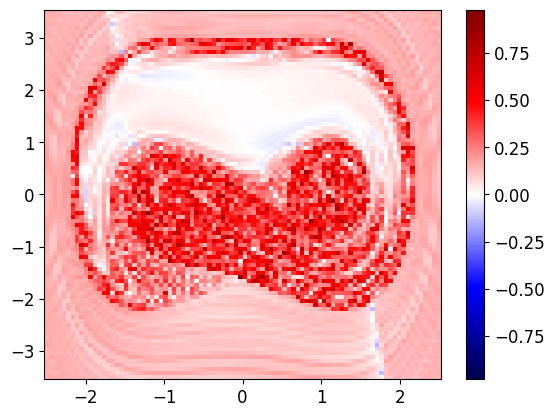

In [645]:
plt.pcolormesh(X,Y, lyaps,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps),np.max(lyaps)])

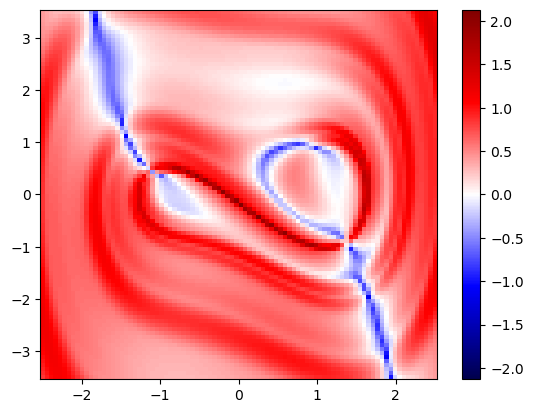

In [428]:
plt.pcolormesh(X,Y, lyaps,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps),np.max(lyaps)])

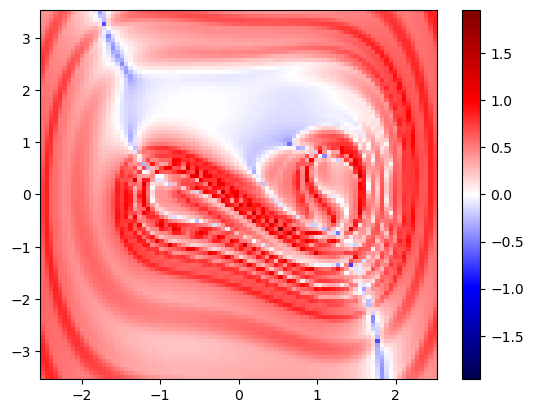

In [408]:
plt.pcolormesh(X,Y, lyaps,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps),np.max(lyaps)])

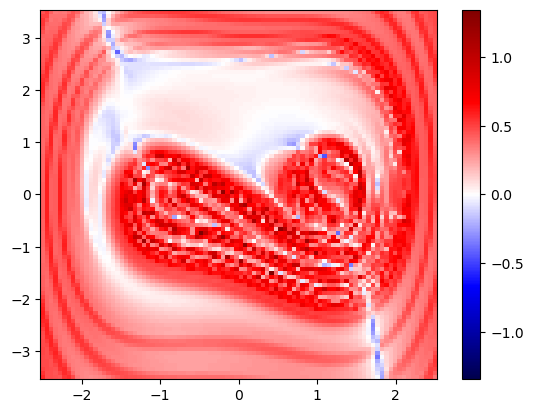

In [411]:
plt.pcolormesh(X,Y, lyaps,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps),np.max(lyaps)])

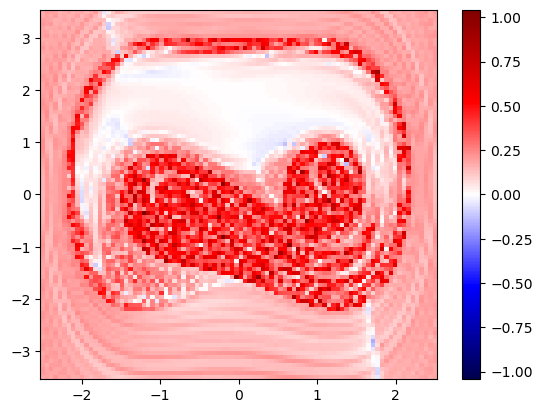

In [415]:
plt.pcolormesh(X,Y, lyaps,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps),np.max(lyaps)])

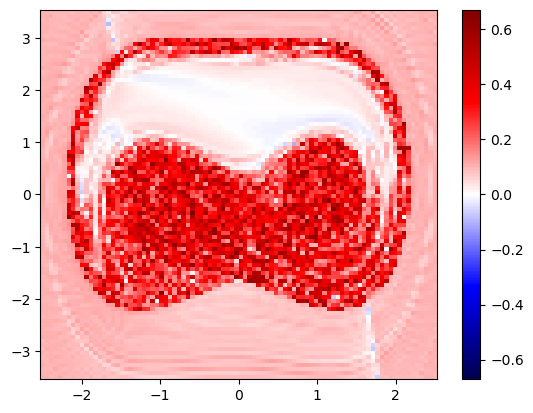

In [419]:
plt.pcolormesh(X,Y, lyaps,cmap='seismic'); plt.colorbar(); plt.clim([-np.max(lyaps),np.max(lyaps)])

Text(0.5, 1.0, 'Poincaré Map')

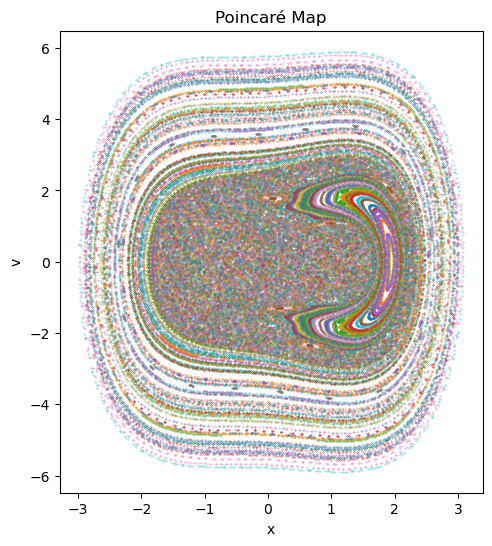

In [38]:
plt.figure(figsize=(12,6))
all_points = np.array(xv) # (t, IC, xv)
plt.subplot(121)
tStart = 100
plt.plot(all_points[tStart:,:,0], all_points[tStart:,:,1], '.', ms=0.5)
plt.xlabel('x'); plt.ylabel('v'); plt.title('Poincaré Map')

Can settle on a specific strange attractor: (b, F, omega, T = 0.3, 0.3, 1.2, 0.01)

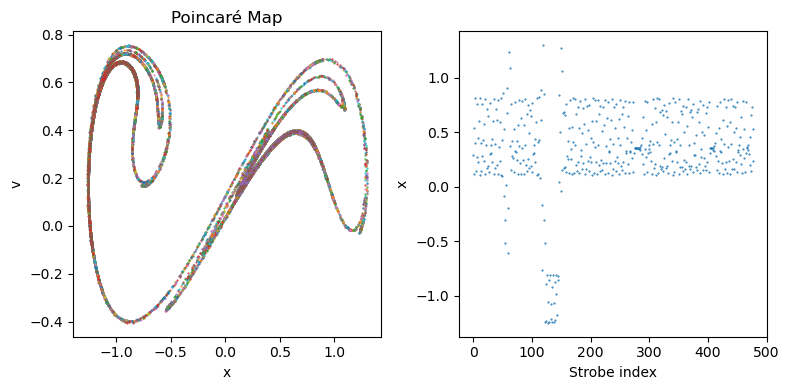

In [24]:
# Visualization
plt.figure(figsize=(8,4))
all_points = np.array(xv) # (t, IC, xv)
plt.subplot(121)
tStart = 10
plt.plot(all_points[tStart:,:,0], all_points[tStart:,:,1], '.', ms=1)
plt.xlabel('x'); plt.ylabel('v'); plt.title('Poincaré Map')

plt.subplot(122)
# Example trajectory
idx = 0
x_traj = all_points[:,idx,0]
plt.plot(np.arange(len(x_traj)), x_traj, '.', ms=1)
plt.xlabel('Strobe index'); plt.ylabel('x')
plt.tight_layout(); plt.show()